In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Restrict multithreading within statsmodels
os.environ["OMP_NUM_THREADS"] = "1"       # OpenMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # OpenBLAS
os.environ["MKL_NUM_THREADS"] = "1"       # Intel MKL
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  # macOS Accelerate
os.environ["NUMEXPR_NUM_THREADS"] = "1"   # NumExpr (used by pandas sometimes)

In [3]:
import datetime
from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import LogLocator, ScalarFormatter

from scipy.stats import kstest, binomtest, chi2

from joblib import Parallel, delayed

In [4]:
n_cores = 18

spark = (
    SparkSession.builder
    .master(f"local[{n_cores}]")
    .appName("Saturation")
    .config("spark.sql.shuffle.partitions", "500")
    .config("spark.driver.memory", "50g")
    .config("spark.driver.maxResultSize", "16g")
    .getOrCreate()
)

25/03/02 06:56:46 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/03/02 06:56:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/02 06:56:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
base_path = "/data/saturation/thesis_run_20250223/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_pdf, configs_df, configs_dict = get_configs(
    base_path=base_path,
    spark=spark
)

25/03/02 06:56:49 WARN CacheManager: Asked to cache already cached data.        


# Modeling each simulation separately

In [143]:
min_simulation_id = 1
max_simulation_id = 150
selected_simulation_ids = list(range(min_simulation_id, max_simulation_id + 1))

In [144]:
df = get_statistics_with_lifespans_for_simulations(
    simulation_ids=selected_simulation_ids,
    base_path=base_path,
    configs_df=configs_df,
    spark=spark,
    n_samples_per_sim=5000
)

In [145]:
models_by_id = dict()

for simulation_id in df.simulation_id.drop_duplicates():
    d = df[df.simulation_id == simulation_id]

    # Fit a negative binomial model
    try:
        model = smf.negativebinomial(data=d, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="bfgs", cov_type="HC0")
        models_by_id[simulation_id] = model
    except:
        pass

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

         Current function value: 14.656045
         Iterations: 12
         Function evaluations: 64
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 15.024888
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 15.433461
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 15.830019
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 16.230817
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 16.620688
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converg

         Current function value: 17.012092
         Iterations: 10
         Function evaluations: 71
         Gradient evaluations: 60
         Current function value: 17.391620
         Iterations: 11
         Function evaluations: 43
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 17.777533
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 18.204213
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.652726
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

         Current function value: 14.970211
         Iterations: 11
         Function evaluations: 53
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 15.355727
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.726096
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converg

         Current function value: 16.085996
         Iterations: 9
         Function evaluations: 57
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 16.440397
         Iterations: 12
         Function evaluations: 92
         Gradient evaluations: 90


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Optimization terminated successfully.
         Current function value: 16.815643
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 17.178697
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 17.524191
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 17.895201
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.633056
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.953662
         Iterations: 10
         Function evaluations: 13


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 15.264498
         Iterations: 12
         Function evaluations: 73
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 15.614878
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
         Current function value: 15.954571
         Iterations: 11
         Function evaluations: 68
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 16.303214
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converg

         Current function value: 16.611626
         Iterations: 9
         Function evaluations: 97
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 16.939309
         Iterations: 12
         Function evaluations: 20
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 17.265885
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
         Current function value: 17.607103
         Iterations: 10
         Function evaluations: 38
         Gradient evaluations: 27


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihoo

         Current function value: 14.619944
         Iterations: 9
         Function evaluations: 70
         Gradient evaluations: 58
         Current function value: 14.897456
         Iterations: 9
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 15.219702
         Iterations: 9
         Function evaluations: 67
         Gradient evaluations: 56


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihoo

         Current function value: 15.525568
         Iterations: 10
         Function evaluations: 51
         Gradient evaluations: 41
         Current function value: 15.798647
         Iterations: 11
         Function evaluations: 65
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 16.085279
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 16.420829
         Iterations: 12
         Function evaluations: 80
         Gradient evaluations: 78
Optimization terminated successfully.
         Current function value: 16.714692
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 17.003231
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
  

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

         Current function value: 14.596864
         Iterations: 11
         Function evaluations: 131
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: 14.890449
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.131044
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.395295
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
         Current function value: 15.653640
         Iterations: 10
         Function evaluations: 69
         Gradient evaluations: 57


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/maso

Optimization terminated successfully.
         Current function value: 15.914330
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 16.193635
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 16.442147
         Iterations: 7
         Function evaluations: 50
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 16.714601
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 16.982329
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

         Current function value: 14.568003
         Iterations: 8
         Function evaluations: 62
         Gradient evaluations: 51
         Current function value: 14.805002
         Iterations: 10
         Function evaluations: 126
         Gradient evaluations: 114


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Optimization terminated successfully.
         Current function value: 15.022523
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.249269
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.505774
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.712232
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.953441
         Iterations: 10
         Function evaluations: 18
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 16.172881
         Iterations: 11
         Function evaluations: 

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converg

Optimization terminated successfully.
         Current function value: 16.397277
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
         Current function value: 16.637556
         Iterations: 11
         Function evaluations: 39
         Gradient evaluations: 30


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihoo

         Current function value: 14.568198
         Iterations: 8
         Function evaluations: 85
         Gradient evaluations: 76
         Current function value: 14.749418
         Iterations: 7
         Function evaluations: 77
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 14.927694
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.112008
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.309557
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 15.521476
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.707368
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 15.887235
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
         Current function value: 16.079477
         Iterations: 10
         Function evaluations: 75
         Gradient evaluations: 66


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 16.280749
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.515798
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 14.659525
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 14.812374
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 14.968021
         Iterations: 10
         Function evaluations: 43
         Gradient evaluations: 32


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihoo

         Current function value: 15.103210
         Iterations: 11
         Function evaluations: 78
         Gradient evaluations: 67
         Current function value: 15.254998
         Iterations: 11
         Function evaluations: 77
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 15.417271
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 15.589778
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 15.705630
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.887561
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
 

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 14.743607
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.835529
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.977402
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.069685
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

         Current function value: 15.175073
         Iterations: 12
         Function evaluations: 89
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 15.301436
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.384013
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.180944
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.241135
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 14.326965
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
O

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 14.791269
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.752444
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 13.812548
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 13.840631
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

         Current function value: 13.850697
         Iterations: 7
         Function evaluations: 74
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: 13.891637
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 13.955850
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 13.967830
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 13.978481
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.024126
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 14.077290
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.059620
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.056969
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.070532
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 13.092638
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 13.104963
         Iterations: 7
         Function evaluations: 9


/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 13.131280
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 13.134906
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.163509
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 13.149083
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 12.076415
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 12.080678
         Iterations: 11
         Function evaluations: 

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 12.109412
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 12.098494
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 12.087390
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 12.109864
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 12.104492
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 12.121228
         Iterations: 12
         Function evaluations: 

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 10.939950
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 10.946965
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 10.941896
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 10.968476
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 10.952096
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 10.961163
         Iterations: 11
         Function evaluations: 

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 10.960106
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 10.981188
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 10.968016
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 10.987712
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 9.776182
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 9.781046
         Iterations: 11
         Function evaluations: 13
 

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2391498/3808792140.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Optimization terminated successfully.
         Current function value: 9.796345
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 9.773946
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 9.775885
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 9.790549
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 9.769550
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 9.807914
         Iterations: 9
         Function evaluations: 11
   

In [146]:
estimates = configs_pdf[configs_pdf.simulation_id.isin(models_by_id.keys())].copy()
estimates["beta1"] = [models_by_id[x].params.iloc[1] for x in estimates.simulation_id]
estimates["beta1_std_err"] = [models_by_id[x].bse.iloc[1] for x in estimates.simulation_id]
estimates["beta1_pvalue"] = [models_by_id[x].pvalues.iloc[1] for x in estimates.simulation_id]
estimates["dispersion_statistic"] = [
    np.sum(models_by_id[x].resid_pearson**2) / models_by_id[x].df_resid
    for x in estimates.simulation_id
]

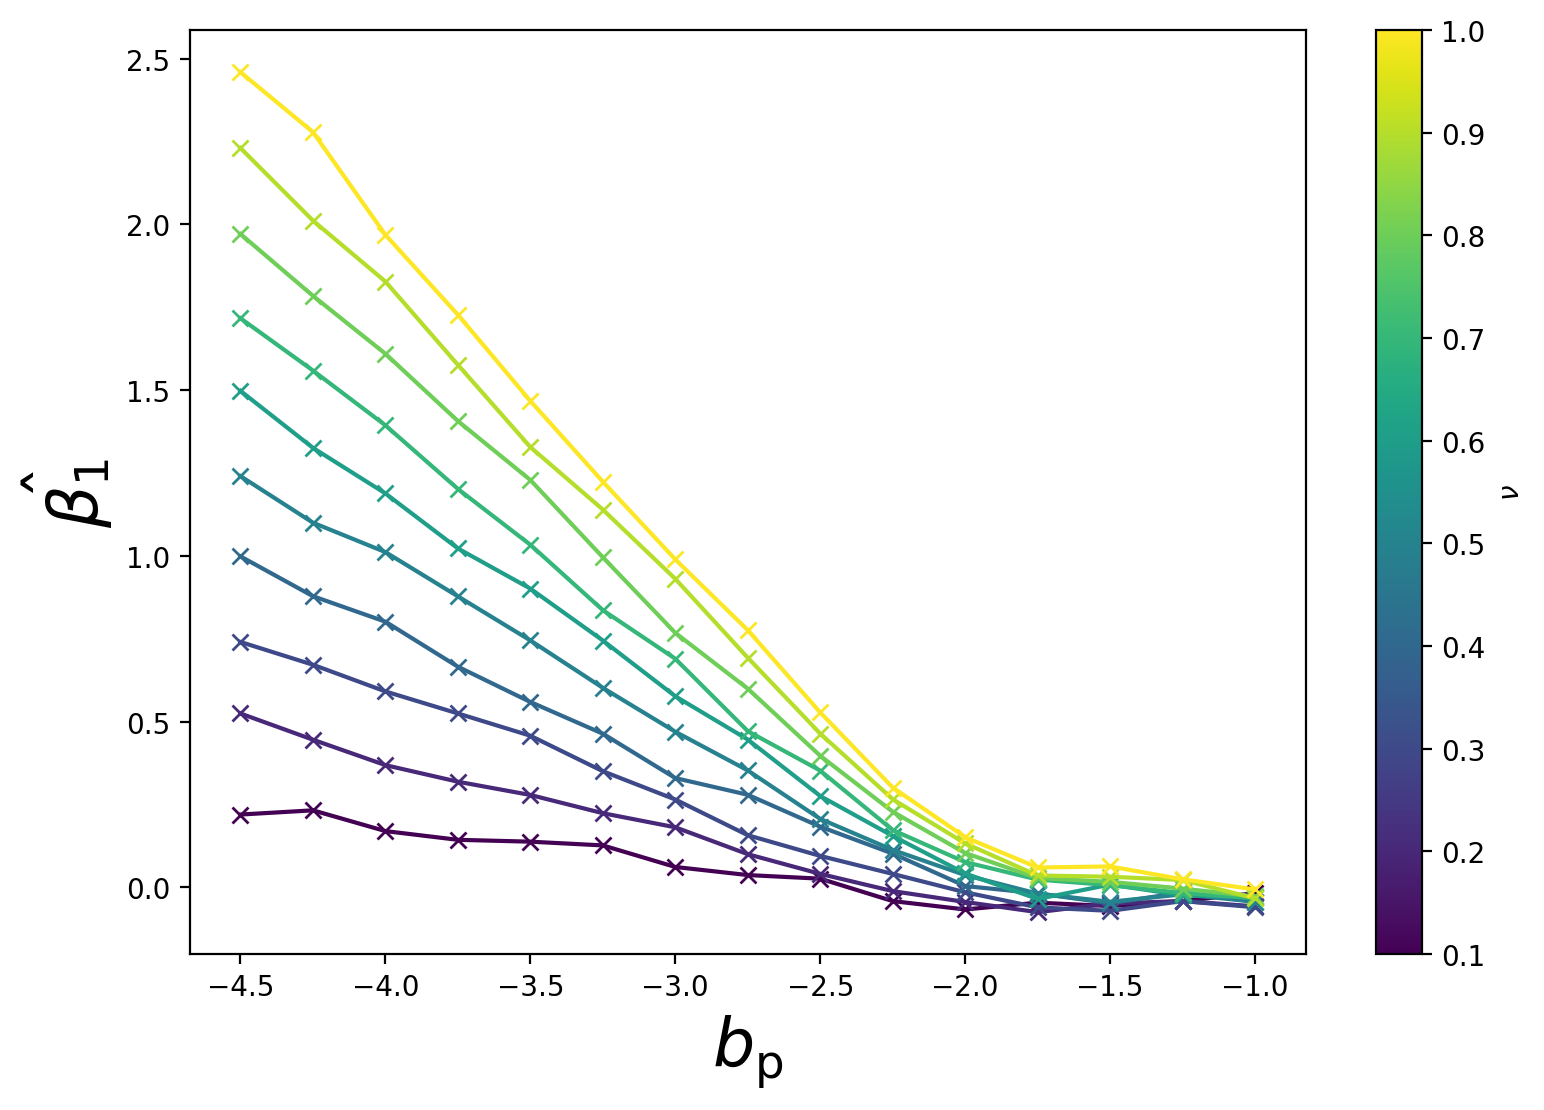

In [147]:
fig = plt.figure(figsize=(9, 6), dpi=200)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(estimates["rim_erasure_exponent"].min(), estimates["rim_erasure_exponent"].max())

for rim_erasure_exponent in estimates.rim_erasure_exponent.drop_duplicates().sort_values():
    d = estimates[estimates.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.plot(
        d.slope,
        d.beta1,
        marker="x",
        color=plt.cm.viridis(norm(rim_erasure_exponent)),
    )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\nu$")

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=font_size)
ax.set_ylabel(r"$\hat{\beta_1}$", fontsize=font_size)

plt.savefig(f"figures/stratified_model_slopes_by_simulation.png", bbox_inches="tight")
plt.show()

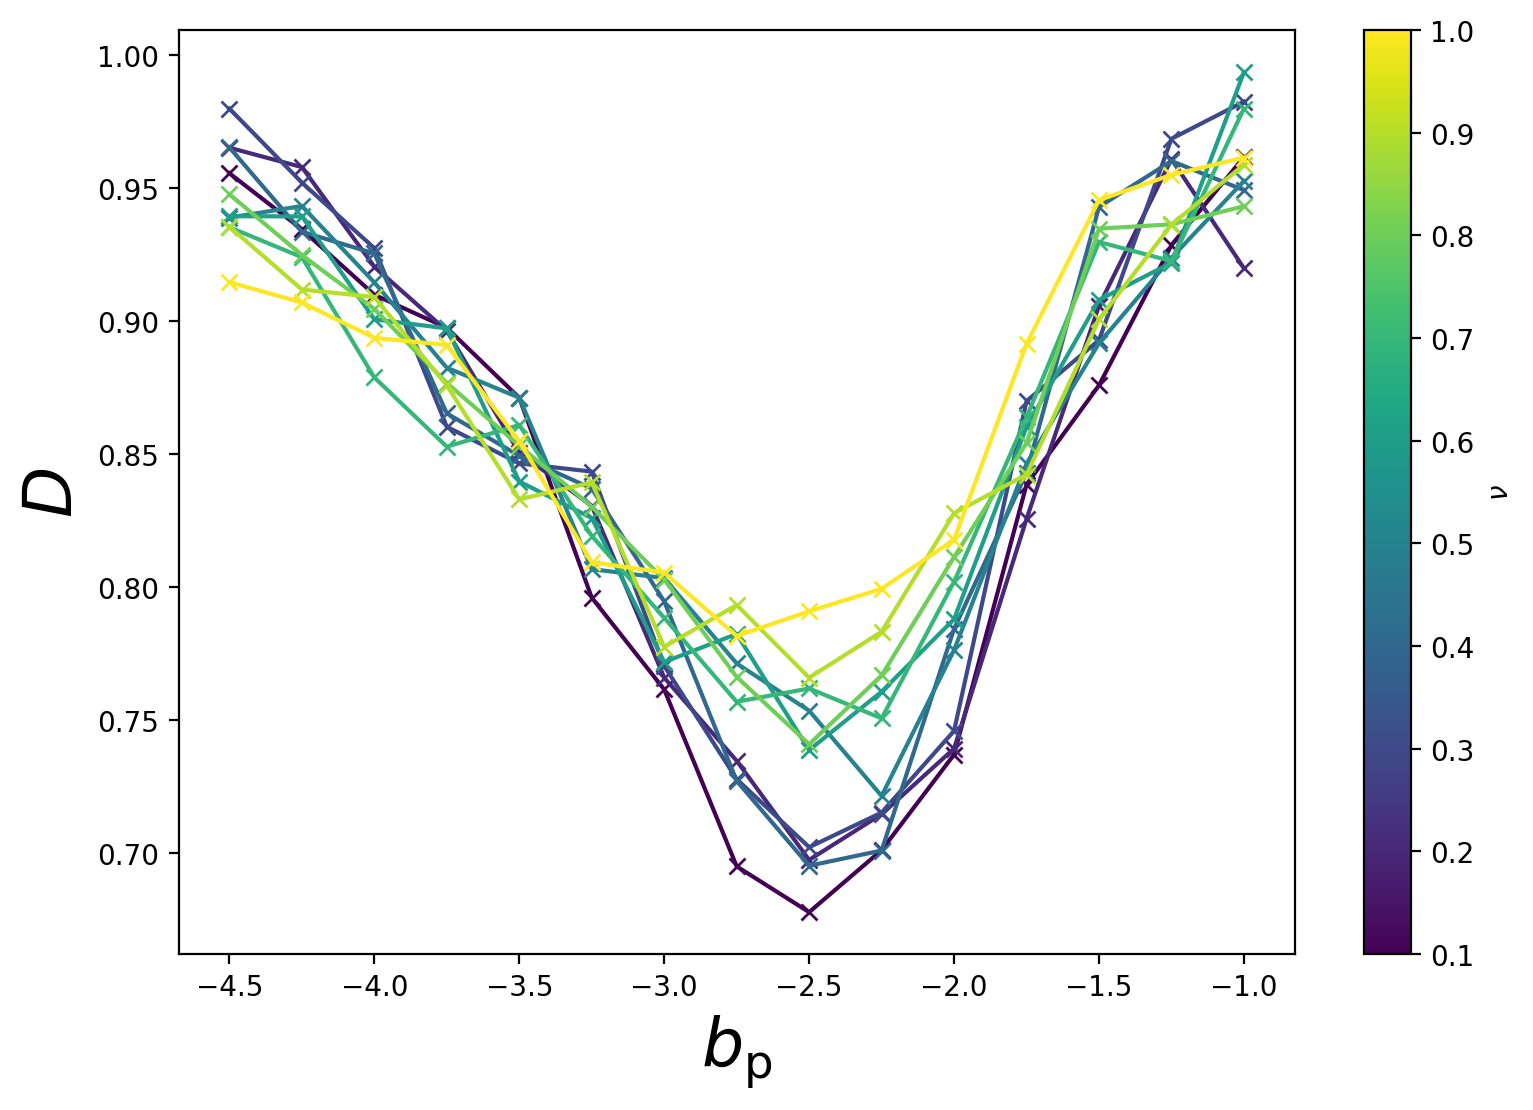

In [148]:
fig = plt.figure(figsize=(9, 6), dpi=200)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(estimates["rim_erasure_exponent"].min(), estimates["rim_erasure_exponent"].max())

for rim_erasure_exponent in estimates.rim_erasure_exponent.drop_duplicates().sort_values():
    d = estimates[estimates.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.plot(
        d.slope,
        d.dispersion_statistic,
        marker="x",
        color=plt.cm.viridis(norm(rim_erasure_exponent)),
    )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\nu$")

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=font_size)
ax.set_ylabel(r"$D$", fontsize=font_size)

plt.savefig(f"figures/stratified_model_dispersion_by_simulation.png", bbox_inches="tight")
plt.show()

## What's with the insignificant p-values?

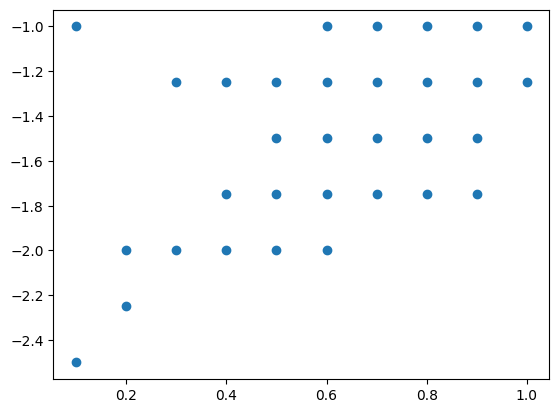

In [150]:
# We have some suspect p-values
large_pvalues = estimates[estimates["beta1_pvalue"] > 1e-2].sort_values("slope")

plt.scatter(
    large_pvalues.rim_erasure_exponent,
    large_pvalues.slope
)

In [151]:
model = smf.ols(data=large_pvalues, formula="slope ~ 1 + rim_erasure_exponent").fit()

# Print the full model summary
print(model.summary())

# Extract and print the slope and intercept
intercept = model.params[0]
slope = model.params[1]

                            OLS Regression Results                            
Dep. Variable:                  slope   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     9.162
Date:                Mon, 24 Feb 2025   Prob (F-statistic):            0.00504
Time:                        14:53:01   Log-Likelihood:                -11.976
No. Observations:                  32   AIC:                             27.95
Df Residuals:                      30   BIC:                             30.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9808 

/tmp/ipykernel_2391498/2022962053.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_2391498/2022962053.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 0.5, 'Count')

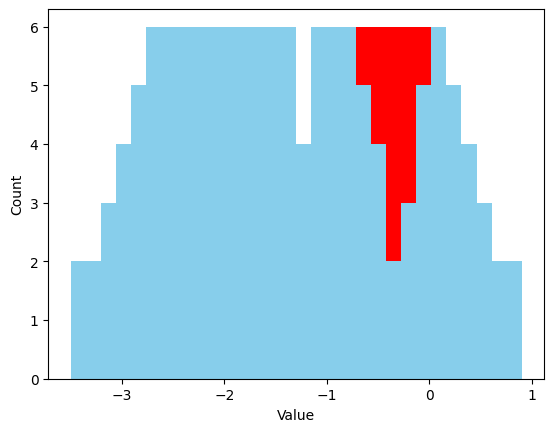

In [226]:
boundary = (estimates.slope + 2) - (1. * estimates.rim_erasure_exponent)
significant = boundary[estimates.beta1_pvalue < 1e-6]
insignificant = boundary[estimates.beta1_pvalue > 1e-6]

# Plot the stacked histogram
plt.hist(
    [significant, insignificant],
    bins=30,
    stacked=True,
    color=['skyblue', 'red'],
    label=['Class A', 'Class B'])
plt.xlabel('Value')
plt.ylabel('Count')

# Prepare and write out data for the pooled model

In [6]:
max_nstat = int(2.5e6)
min_nstat = int(1.25e6)
n_nstats = 1000
step = int((max_nstat - min_nstat) / n_nstats)

nstats = [min_nstat + x * step for x in range(n_nstats)]

max_nstat_for_statistics = int(1e6)
max_radius = 500
max_slope = -2.5

min_simulation_id = 1
max_simulation_id = 150
selected_simulation_ids = range(min_simulation_id, max_simulation_id + 1)
filtered_configs_pdf = configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].copy()

In [9]:
first_sim_id = selected_simulation_ids[0]
study_region_size = configs_dict[first_sim_id]["study_region_size"]
study_region_padding = configs_dict[first_sim_id]["study_region_padding"]

for simulation_id in selected_simulation_ids:
    stats_df = spark.read.parquet(f"{base_path}/{simulation_id}/statistics_*.parquet")
    craters_df = spark.read.parquet( f"{base_path}/{simulation_id}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{base_path}/{simulation_id}/crater_removals_*.parquet")
    
    states = get_states(
        stats_df=stats_df,
        craters_df=craters_df,
        removals_df=removals_df,
        nstats=nstats,
        study_region_size=study_region_size,
        study_region_padding=study_region_padding,
        spark=spark,
        result_columns=["crater_id", "radius", "nstat"],
        max_radius=max_radius
    )
    states["simulation_id"] = simulation_id
    states = states.set_index("simulation_id").sort_index()
    states.to_parquet(f"data/states_{simulation_id}_{n_nstats}.parquet")

In [ ]:
slopes = []
for nstat in nstats:
    state = states[(states.index.isin(selected_simulation_ids)) & (states.nstat == nstat)].copy()
    try:
        estimates = estimate_slopes_for_states({1: state}, 3.0)
        slopes.append(estimates.alpha.squeeze())
    except:
        pass

In [ ]:
triple_coef = -0.9603
double_coef = -1.8246
rim_erasure_exponent = configs_dict[selected_simulation_ids[0]]["rim_erasure_method"]["exponent"]
b_p = configs_dict[selected_simulation_ids[0]]["slope"]
est_slope = b_p + (triple_coef * b_p * rim_erasure_exponent + rim_erasure_exponent*double_coef)
est_slope - 0.1, est_slope + 0.1

In [ ]:
s = pd.Series(slopes)
s.quantile(0.975), s.quantile(0.025)

In [ ]:
_, alpha, sigma = estimate_slopes_for_states({1: states}, 3.0).squeeze()
alpha - 1.96 * sigma, alpha + 1.96 * sigma

In [69]:
# Old version, one state at nstat
# first_sim_id = selected_simulation_ids[0]
# study_region_size = configs_dict[first_sim_id]["study_region_size"]
# study_region_padding = configs_dict[first_sim_id]["study_region_padding"]

# stats_df = spark.read.parquet(f"{base_path}/{selected_simulation_ids[0]}/statistics_*.parquet")
# craters_df = spark.read.parquet( f"{base_path}/{selected_simulation_ids[0]}/craters_*.parquet")
# removals_df = spark.read.parquet(f"{base_path}/{selected_simulation_ids[0]}/crater_removals_*.parquet")
# for simulation_id in selected_simulation_ids[1:]:
#     stats_df = stats_df.unionByName(spark.read.parquet(f"{base_path}/{simulation_id}/statistics_*.parquet"))
#     craters_df = craters_df.unionByName(spark.read.parquet( f"{base_path}/{simulation_id}/craters_*.parquet"))
#     removals_df = removals_df.unionByName(spark.read.parquet(f"{base_path}/{simulation_id}/crater_removals_*.parquet"))

# states = get_state_at_time(
#     stats_df=stats_df,
#     craters_df=craters_df,
#     removals_df=removals_df,
#     target_nstat=target_nstat,
#     study_region_size=study_region_size,
#     study_region_padding=study_region_padding,
#     spark=spark,
#     result_columns=["simulation_id", "radius"],
#     max_radius=max_radius
# )
# states = states.set_index("simulation_id").sort_index()
# states.to_parquet("data/states.parquet")

25/02/25 09:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1501.7 KiB


In [7]:
result_columns = [
    "radius",
    "lifespan",
    "simulation_id"
]
statistics = get_statistics_with_lifespans_for_simulations(
    simulation_ids=selected_simulation_ids,
    base_path=base_path,
    configs_df=configs_df,
    spark=spark,
    result_columns=result_columns,
    max_nstat=max_nstat_for_statistics,
    max_radius=max_radius
)
statistics = statistics.set_index("simulation_id").sort_index()
statistics.to_parquet("data/statistics.parquet")

# Bootstrapped KS margin test

In [142]:
# def truncated_pareto_cdf(
#     *,
#     x: np.ndarray,
#     alpha: float,
#     xmin: float,
#     xmax: float
# ) -> np.ndarray:
#     """
#     CDF of truncated Pareto distribution.

#     Parameters:
#         x (np.ndarray): Points at which to evaluate the CDF.
#         b (float): Pareto shape parameter.
#         xmin (float): Lower bound of truncation.
#         xmax (float): Upper bound of truncation.

#     Returns:
#         np.ndarray: CDF values evaluated at x.
#     """
#     x = np.asarray(x)
#     cdf = np.zeros_like(x, dtype=float)

#     norm_const = xmin**(-alpha) - xmax**(-alpha)

#     in_bounds = (x >= xmin) & (x <= xmax)
#     cdf[in_bounds] = (xmin**(-alpha) - x[in_bounds]**(-alpha)) / norm_const
#     cdf[x > xmax] = 1.0

#     return cdf


# def truncated_pareto_rvs(
#     *,
#     alpha: float,
#     xmin: float,
#     xmax: float,
#     size: int
# ) -> np.ndarray:
#     """
#     Generate random samples from truncated Pareto.
#     """
#     u = np.random.uniform(size=size)
#     samples = (xmin**(-alpha) - u * (xmin**(-alpha) - xmax**(-alpha)))**(-1 / alpha)
#     return samples


# def bootstrap_margin_ks(
#     *,
#     alpha: float,
#     xmin: float,
#     xmax: float,
#     sample_size: int,
#     quantile: float,
#     n_bootstrap: int
# ) -> float:
#     """
#     Bootstrap KS margin for truncated Pareto.
#     """
#     stats = [
#         kstest(
#             truncated_pareto_rvs(alpha=alpha, xmin=xmin, xmax=xmax, size=sample_size),
#             lambda x: truncated_pareto_cdf(x=x, alpha=alpha, xmin=xmin, xmax=xmax)
#         )[0]
#         for _ in range(n_bootstrap)
#     ]
#     return np.quantile(stats, quantile)


# def within_sample_test(
#     *,
#     sample: np.ndarray,
#     predicted_alpha: float,
#     xmin: float,
#     xmax: float,
#     margin: float
# ) -> tuple[float, bool]:
#     """
#     Perform within-sample equivalence test.
#     """
#     ks_stat, _ = kstest(
#         sample,
#         lambda x: truncated_pareto_cdf(x=x, alpha=predicted_alpha, xmin=xmin, xmax=xmax)
#     )
#     is_equivalent = ks_stat < margin
#     return ks_stat, is_equivalent[0]


# def perform_two_level_test(
#     *,
#     data_samples: list[np.ndarray],
#     predicted_slopes: list[float],
#     simulation_ids: list[int],
#     xmin: float,
#     xmax: float,
#     confidence_alpha: float,
#     quantile: float,
#     n_bootstrap: int
# ) -> tuple[list[dict], dict]:
#     """
#     Conduct two-level hypothesis testing framework.
#     """
#     n_samples = len(data_samples)
#     results = []

#     # Level 1: Within-sample testing
#     for simulation_id, sample, predicted_slope in zip(simulation_ids, data_samples, predicted_slopes):
#         predicted_alpha = -predicted_slope
#         margin = bootstrap_margin_ks(
#             alpha=predicted_alpha,
#             xmin=xmin,
#             xmax=xmax,
#             sample_size=len(sample),
#             quantile=quantile,
#             n_bootstrap=n_bootstrap
#         )
#         ks_stat, equivalent = within_sample_test(
#             sample=sample,
#             predicted_alpha=predicted_alpha,
#             xmin=xmin,
#             xmax=xmax,
#             margin=margin
#         )
#         results.append({
#             "simulation_id": simulation_id,
#             "ks_stat": ks_stat,
#             "margin": margin,
#             "equivalent": equivalent
#         })

#     # Level 2: Across-sample testing
#     equivalence_results = [r["equivalent"] for r in results]
#     n_equiv = sum(equivalence_results)

#     # Hypothesis: H0: proportion_equivalent <= 0.5, Ha: proportion_equivalent > 0.5
#     p_val = binomtest(n_equiv, n_samples, p=0.5, alternative="greater").pvalue

#     summary = {
#         "total_samples": n_samples,
#         "equivalent_samples": n_equiv,
#         "equivalence_proportion": n_equiv / n_samples,
#         "p_value": p_val,
#         "reject_null": p_val < confidence_alpha
#     }

#     return results, summary

In [200]:
def truncated_pareto_cdf(*, x: np.ndarray, alpha: float, xmin: float, xmax: float) -> np.ndarray:
    x = np.asarray(x)
    cdf = np.zeros_like(x, dtype=float)
    norm_const = xmin**(-alpha) - xmax**(-alpha)
    in_bounds = (x >= xmin) & (x <= xmax)
    cdf[in_bounds] = (xmin**(-alpha) - x[in_bounds]**(-alpha)) / norm_const
    cdf[x > xmax] = 1.0
    return cdf

def truncated_pareto_rvs(*, alpha: float, xmin: float, xmax: float, size: int) -> np.ndarray:
    u = np.random.uniform(size=size)
    samples = (xmin**(-alpha) - u * (xmin**(-alpha) - xmax**(-alpha)))**(-1 / alpha)
    return samples

def bootstrap_margin_ks(*, alpha: float, xmin: float, xmax: float, sample_size: int, quantile: float, n_bootstrap: int) -> float:
    stats = [
        kstest(
            truncated_pareto_rvs(alpha=alpha, xmin=xmin, xmax=xmax, size=sample_size),
            lambda x: truncated_pareto_cdf(x=x, alpha=alpha, xmin=xmin, xmax=xmax)
        )[0]
        for _ in range(n_bootstrap)
    ]
    return np.quantile(stats, quantile)

def within_sample_test(*, sample: np.ndarray, predicted_alpha: float, xmin: float, xmax: float, margin: float) -> tuple[float, bool, float]:
    """
    Perform within-sample equivalence test.
    Returns: KS statistic, equivalence decision (boolean), and the KS p-value.
    """
    ks_stat, ks_p_value = kstest(
        sample,
        lambda x: truncated_pareto_cdf(x=x, alpha=predicted_alpha, xmin=xmin, xmax=xmax)
    )
    is_equivalent = ks_stat[0] < margin
    return ks_stat[0], is_equivalent, ks_p_value[0]

def combine_pvalues_tippett(p_values: list[float]) -> float:
    """
    Combine individual p-values using Tippett's method.
    Under the null (that at least one sample is nonconforming), the minimum p-value p_(1)
    follows: P(p_(1) ≤ t) = 1 - (1 - t)^N.
    The combined p-value is then:
        p_combined = 1 - (1 - min(p_values))^N.
    """
    N = len(p_values)
    p_min = min(p_values)
    p_combined = 1 - (1 - p_min) ** N
    return p_combined

def perform_inverted_test(
    *,
    data_samples: list[np.ndarray],
    predicted_slopes: list[float],
    simulation_ids: list[int],
    xmin: float,
    xmax: float,
    quantile: float,
    n_bootstrap: int,
    overall_alpha: float
) -> tuple[list[dict], dict]:
    """
    Perform the inverted testing procedure where the null hypothesis is that
    some sample is not drawn from the predicted distribution.
    """
    n_samples = len(data_samples)
    results = []
    ks_p_values = []

    # Individual KS tests (within-sample)
    for simulation_id, sample, predicted_slope in zip(simulation_ids, data_samples, predicted_slopes):
        predicted_alpha = -predicted_slope
        margin = bootstrap_margin_ks(
            alpha=predicted_alpha,
            xmin=xmin,
            xmax=xmax,
            sample_size=len(sample),
            quantile=quantile,
            n_bootstrap=n_bootstrap
        )
        ks_stat, equivalent, ks_p_value = within_sample_test(
            sample=sample,
            predicted_alpha=predicted_alpha,
            xmin=xmin,
            xmax=xmax,
            margin=margin
        )
        results.append({
            "simulation_id": simulation_id,
            "ks_stat": ks_stat,
            "margin": margin,
            "equivalent": equivalent,
            "ks_p_value": ks_p_value
        })
        ks_p_values.append(ks_p_value)

    # Inverted test: H0: At least one sample is nonconforming.
    # Using Fisher's method, compute the combined p-value.
    fishers_test_statistic, combined_p_value = scipy.stats.combine_pvalues(ks_p_values, method="fisher")
    
    # If combined p-value is low, there is no evidence for any nonconforming sample,
    # so reject H0 and conclude all samples are drawn from the predicted distribution.
    reject_null = combined_p_value < overall_alpha

    summary = {
        "total_samples": n_samples,
        "combined_p_value": combined_p_value,
        "fishers_test_statistic": fishers_test_statistic,
        "reject_null": reject_null  # True means all samples conform (i.e., null is rejected)
    }

    return results, summary

In [214]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def mle_truncated_pareto(data, D_min, D_max):
    """
    Compute the maximum likelihood estimate (MLE) for the truncated Pareto parameter a.
    For a truncated Pareto with PDF:
      f(D) = a * (D_min**a / D**(a+1)) / (1 - (D_min/D_max)**a)    for D in [D_min, D_max],
    the MLE estimate â satisfies:
      N / â + N * ((D_min/D_max)**â * ln(D_min/D_max))/(1 - (D_min/D_max)**â)
      = sum_{i=1}^N [ln(D_i) - ln(D_min)].
      
    Parameters:
      data: 1D numpy array of observed values (assumed D_min <= data <= D_max)
      D_min: lower bound for the fit (can be set as min(data) or a chosen completeness limit)
      D_max: upper bound for the fit (e.g. max(data) or a user‐defined cutoff)
      
    Returns:
      a_hat: the MLE estimate of the Pareto parameter a.
    """
    N = len(data)
    sum_logs = np.sum(np.log(data) - np.log(D_min))
    
    # Define the function whose root gives the MLE estimate
    def f(a):
        # To avoid division by zero, a must be > 0.
        term = ((D_min / D_max)**a * np.log(D_min / D_max)) / (1 - (D_min / D_max)**a)
        return N / a + N * term - sum_logs
    
    # Use the non-truncated Pareto MLE as a starting point: a0 = N / sum(log(data/D_min))
    a0 = N / sum_logs
    # Define a bracket for a: we choose [a0/10, 10*a0]. Adjust if needed.
    lower = max(a0 / 10, 1e-6)
    upper = a0 * 10
    # In case f(lower) and f(upper) have the same sign, expand the interval.
    if f(lower) * f(upper) > 0:
        upper = a0 * 100
    sol = root_scalar(f, bracket=[lower, upper], method='bisect')
    if sol.converged:
        return sol.root
    else:
        raise RuntimeError("Root finding for the MLE did not converge.")

def bootstrap_mle_slope(data, D_min, D_max, n_bootstrap=1000, random_state=None):
    """
    Perform bootstrap resampling to obtain a distribution of the MLE estimate of the slope.
    The "slope" is defined as alpha = a_hat + 1.
    
    Parameters:
      data: 1D numpy array of observed data (crater diameters, for example)
      D_min: lower truncation bound (or completeness limit)
      D_max: upper truncation bound
      n_bootstrap: number of bootstrap iterations (default 1000)
      random_state: optional seed for reproducibility
      
    Returns:
      slopes: a numpy array of bootstrap estimates of the slope (alpha)
    """
    if random_state is not None:
        np.random.seed(random_state)
    n = len(data)
    slopes = []
    for i in range(n_bootstrap):
        # Sample with replacement from the original data
        sample = np.random.choice(data, size=n, replace=True)
        try:
            a_hat = mle_truncated_pareto(sample, D_min, D_max)
            # The DSFD “slope” is often defined as alpha = a_hat + 1.
            slopes.append(a_hat)
        except Exception as e:
            # Optionally, handle bootstrap failures (e.g., skip iteration)
            continue
    return np.array(slopes)

# ---------------------------
# Example usage:
# ---------------------------
# (For demonstration, here we simulate a sample of crater diameters.)
def simulate_truncated_pareto(n, D_min, D_max, a):
    """
    Simulate n samples from a truncated Pareto distribution with given parameters.
    The CDF of the truncated Pareto is:
      F(D) = (1 - (D_min/D)**a) / (1 - (D_min/D_max)**a)
    Inverting this, a random sample is given by:
      D = D_min / (1 - u*(1 - (D_min/D_max)**a))^(1/a),
    where u ~ Uniform(0, 1).
    """
    u = np.random.uniform(0, 1, size=n)
    return D_min / (1 - u*(1 - (D_min/D_max)**a))**(1/a)

# Set parameters for simulation (for example, true a=2 so that true slope alpha = 3)
D_min = 3.0
D_max = 500.0
true_a = 4.5  # so true slope = true_a + 1 = 3.0

# Generate a sample dataset
np.random.seed(0)
# data = simulate_truncated_pareto(1000, D_min, D_max, true_a)
data = states[states.index == 1].radius.copy()

# Compute the MLE for the full sample
a_hat = mle_truncated_pareto(data, D_min, D_max)
print(f"MLE estimate for a: {a_hat:.3f}")

# Bootstrap the slope estimate
n_bootstrap = 100000
bootstrap_slopes = bootstrap_mle_slope(data, D_min, D_max, n_bootstrap=n_bootstrap, random_state=42)

# Plot the bootstrap distribution
plt.hist(bootstrap_slopes, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(a_hat, color='red', linestyle='--', label=f"Original MLE slope = {slope_estimate:.2f}")
plt.xlabel("Bootstrap MLE slope (alpha)")
plt.ylabel("Density")
plt.title("Bootstrap Distribution of MLE Slope Estimate")
plt.legend()
plt.show()

# Compute and print bootstrap statistics
mean_boot = np.mean(bootstrap_slopes)
std_boot = np.std(bootstrap_slopes, ddof=1)
print(f"Bootstrap mean slope: {mean_boot:.3f}")
print(f"Bootstrap standard deviation: {std_boot:.3f}")


MLE estimate for a: 4.612


Bootstrap mean slope: 4.653
Bootstrap standard deviation: 0.446


In [215]:
states[states.index == 1]

radius
simulation_id          
1              3.385935
1              4.038440
1              3.945085
1              3.228745
1              3.311716
...                 ...
1              3.123899
1              3.304878
1              5.105239
1              3.313444
1              3.602336

[114 rows x 1 columns]

In [207]:
estimate_truncated_pareto_alpha(states[states.index == 1].radius.copy(), 3.0, 500.0)

(5.611965701874458, 0.4319501707945486)

In [27]:
target_nstat = int(2.5e6)
max_nstat_for_statistics = int(1e6)
max_radius = 30
max_slope = -2.5

min_simulation_id = 1
max_simulation_id = 150
selected_simulation_ids = list(
    configs_pdf[configs_pdf.simulation_id.between(min_simulation_id, max_simulation_id) & (configs_pdf.slope <= max_slope)].simulation_id
)
filtered_configs_pdf = configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].copy()

In [28]:
statistics = pd.read_parquet("data/statistics.parquet")
states = pd.read_parquet("data/states.parquet")

In [30]:
statistics_sample = statistics[["lifespan", "slope", "rim_erasure_exponent", "radius"]].sample(100000).copy()

In [31]:
model_formula = (
    "lifespan ~ 1 "
    "+ slope:rim_erasure_exponent:np.log(radius) "
    "+ rim_erasure_exponent:np.log(radius) "
    "+ np.log(-slope)"
)

lifespan_model = smf.negativebinomial(
    data=statistics_sample,
    formula=model_formula
).fit(maxiter=1000, method="BFGS")
lifespan_model.summary()

Optimization terminated successfully.
         Current function value: 15.811503
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               lifespan   No. Observations:               100000
Model:               NegativeBinomial   Df Residuals:                    99996
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                 0.05669
Time:                        18:17:22   Log-Likelihood:            -1.5812e+06
converged:                       True   LL-Null:                   -1.6762e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    12.6724      0.020    619.903      0.000      12.632      12.713
slope:rim_erasure_exponent:np.log(radius)    -0.9603      0.005   -176.729      0.000      -0.971      -0.950
rim_erasure_exponent:np.log(radius)          -1.8246      0.019    -96.688      0.000      -1.862      -1.788
np.log(-slope)                                1.1126      0.016     67.584      0.000       1.080       1.145
alpha                                         0.2323      0.001    232.014      0.000       0.230       0.234
=============================================================================================================
"""

In [56]:
samples = []
predicted_slopes = []
simulation_ids = []

for row in filtered_configs_pdf.itertuples():
    slope = row.slope
    rim_erasure_exponent = row.rim_erasure_exponent
    
    lifespan_exponent = (
        slope * rim_erasure_exponent * lifespan_model.params.iloc[1]
        + rim_erasure_exponent * lifespan_model.params.iloc[2]
    )
    predicted_slope_lifespan = slope + lifespan_exponent

    samples.append(states.loc[row.simulation_id].copy())
    predicted_slopes.append(predicted_slope_lifespan)
    simulation_ids.append(row.simulation_id)

In [201]:
results = perform_inverted_test(
    data_samples=samples,
    predicted_slopes=predicted_slopes,
    simulation_ids=simulation_ids,
    xmin=3.0,
    xmax=500.0,
    n_bootstrap=1000,
    quantile=0.95,
    overall_alpha=0.05
)

In [202]:
results[1]

{'total_samples': 90,
 'combined_p_value': 0.00025718483196538844,
 'fishers_test_statistic': 253.36371013217584,
 'reject_null': True}

In [203]:
ind_results = pd.DataFrame.from_dict(results[0], orient="columns")
ind_results["slope"] = [configs_dict[x]["slope"] for x in ind_results.simulation_id]
ind_results["rim_erasure_exponent"] = [configs_dict[x]["rim_erasure_method"]["exponent"] for x in ind_results.simulation_id]
ind_results

simulation_id   ks_stat    margin  equivalent  ks_p_value  slope  \
0              12  0.065651  0.082444        True    0.208596  -4.25   
1              28  0.015643  0.028695        True    0.656574  -4.00   
2              74  0.009993  0.023763        True    0.896435  -2.75   
3              18  0.019950  0.033403        True    0.495938  -4.25   
4              68  0.017892  0.019964        True    0.088259  -3.00   
..            ...       ...       ...         ...         ...    ...   
85             86  0.011797  0.020351        True    0.584093  -2.50   
86             90  0.023201  0.017142       False    0.002270  -2.50   
87             81  0.014798  0.025925        True    0.541999  -2.50   
88             69  0.012233  0.017906        True    0.352417  -3.00   
89             37  0.043759  0.030174       False    0.000586  -3.75   

    rim_erasure_exponent  
0                    0.2  
1                    0.8  
2                    0.4  
3                    0.8  
4                    0.8  
..                   ...  
85                   0.6  
86                   1.0  
87                   0.1  
88                   0.9  
89                   0.7  

[90 rows x 7 columns]

In [196]:
ind_results.ks_p_value

SignificanceResult(statistic=253.36371013217584, pvalue=0.00025718483196538844)

In [171]:
plt.hist(ind_results.ks_p_value)
ind_results.ks_p_value.describe()

count    90.000000
mean      0.410061
std       0.289627
min       0.000586
25%       0.143783
50%       0.377846
75%       0.621769
max       0.972598
Name: ks_p_value, dtype: float64

In [188]:
ind_results

simulation_id                 ks_stat    margin equivalent  \
0              12   [0.06565109829379823]  0.082781     [True]   
1              28   [0.01564253791903525]  0.029342     [True]   
2              74  [0.009993286048286865]  0.024180     [True]   
3              18  [0.019949741255168685]  0.032528     [True]   
4              68   [0.01789237236768154]  0.018814     [True]   
..            ...                     ...       ...        ...   
85             86  [0.011796647999458787]  0.020553     [True]   
86             90   [0.02320071839635507]  0.017289    [False]   
87             81  [0.014797645604956444]  0.025135     [True]   
88             69  [0.012232783571970218]  0.017746     [True]   
89             37   [0.04375887258553879]  0.028996    [False]   

                 ks_p_value  slope  rim_erasure_exponent  
0      [0.2085963776248717]  -4.25                   0.2  
1      [0.6565738319414849]  -4.00                   0.8  
2      [0.8964352380165563]  -2.75                   0.4  
3      [0.4959378237596196]  -4.25                   0.8  
4     [0.08825924976346455]  -3.00                   0.8  
..                      ...    ...                   ...  
85     [0.5840931442980973]  -2.50                   0.6  
86  [0.0022701446283566926]  -2.50                   1.0  
87     [0.5419986246342876]  -2.50                   0.1  
88    [0.35241653341304324]  -3.00                   0.9  
89  [0.0005859712747620342]  -3.75                   0.7  

[90 rows x 7 columns]

In [172]:
ind_results[~ind_results.equivalent].sort_values("slope")

simulation_id   ks_stat    margin  equivalent  ks_p_value  slope  \
48             27  0.038368  0.033519       False    0.016672  -4.00   
69             33  0.060597  0.050608       False    0.008481  -3.75   
89             37  0.043759  0.029512       False    0.000586  -3.75   
60             50  0.023142  0.018169       False    0.005264  -3.50   
19             56  0.030045  0.026568       False    0.012999  -3.25   
31             64  0.032267  0.027137       False    0.009747  -3.00   
24             88  0.019631  0.018734       False    0.029440  -2.50   
86             90  0.023201  0.017345       False    0.002270  -2.50   

    rim_erasure_exponent  
48                   0.7  
69                   0.3  
89                   0.7  
60                   1.0  
19                   0.6  
31                   0.4  
24                   0.8  
86                   1.0

## Sensitivity Analysis

In [131]:
def sensitivity_analysis(
    *,
    data_samples: list[np.ndarray],
    predicted_slopes: list[float],
    simulation_ids: list[int],
    xmin: float,
    xmax: float,
    quantiles: list[float],
    n_bootstrap: int,
    confidence_alpha: float
) -> pd.DataFrame:
    """
    Perform sensitivity analysis over multiple quantiles.

    Returns:
        DataFrame summarizing equivalence proportions across quantiles.
    """
    results = []

    for q in quantiles:
        _, summary = perform_two_level_test(
            data_samples=data_samples,
            predicted_slopes=predicted_slopes,
            simulation_ids=simulation_ids,
            xmin=xmin,
            xmax=xmax,
            quantile=q,
            n_bootstrap=n_bootstrap,
            confidence_alpha=confidence_alpha
        )

        results.append({
            "quantile": q,
            "equivalence_proportion": summary["equivalence_proportion"],
            "equivalent_samples": summary["equivalent_samples"],
            "total_samples": summary["total_samples"],
            "p_value": summary["p_value"],
            "reject_null": summary["reject_null"]
        })

    df_results = pd.DataFrame(results)
    
    # Visualization for quick interpretation:
    plt.figure(figsize=(8, 5))
    plt.plot(df_results["quantile"], df_results["equivalence_proportion"], marker="o")
    plt.xlabel("Bootstrap Quantile")
    plt.ylabel("Proportion Equivalent")
    plt.title("Sensitivity Analysis of Bootstrap Quantile")
    plt.grid(True)
    plt.show()

    return df_results

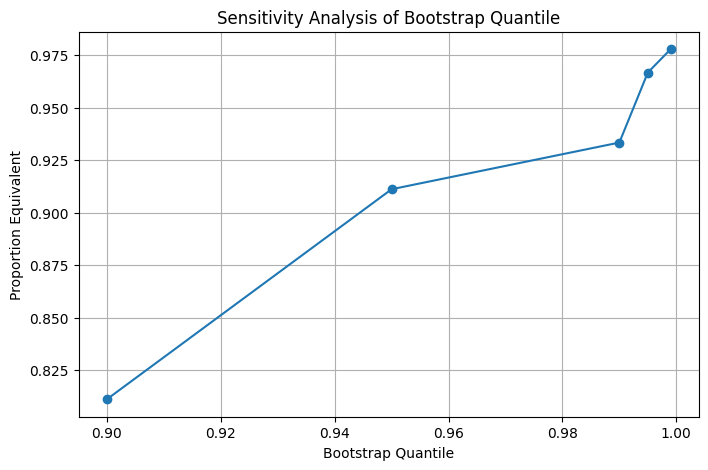

   quantile  equivalence_proportion  equivalent_samples  total_samples  \
0     0.900                0.811111                  73             90   
1     0.950                0.911111                  82             90   
2     0.990                0.933333                  84             90   
3     0.995                0.966667                  87             90   
4     0.999                0.977778                  88             90   

        p_value  reject_null  
0  9.741188e-10         True  
1  6.919248e-17         True  
2  5.406083e-19         True  
3  9.820831e-23         True  
4  3.308722e-24         True  


In [134]:
quantiles_to_test = [0.90, 0.95, 0.99, 0.995, 0.999]
sensitivity_df = sensitivity_analysis(
    data_samples=samples,
    predicted_slopes=predicted_slopes,
    simulation_ids=simulation_ids,
    xmin=3.0,
    xmax=500.0,
    quantiles=quantiles_to_test,
    confidence_alpha=0.05,
    n_bootstrap=1000
)
print(sensitivity_df)

# A pooled model

In [95]:
target_ntot = int(2.5e6)
# max_radius = 20
max_radius = 500
max_slope = -2.5

min_simulation_id = 1
max_simulation_id = 150
selected_simulation_ids = list(
    configs_pdf[configs_pdf.simulation_id.between(min_simulation_id, max_simulation_id) & (configs_pdf.slope <= max_slope)].simulation_id
)

In [96]:
states = dict()
for simulation_id in selected_simulation_ids:
    states[simulation_id] = get_states_at_ntats(
        simulation_id=simulation_id,
        configs_dict=configs_dict,
        base_path=base_path,
        target_nstats=[target_ntot],
        spark=spark,
        max_radius=max_radius
    )[target_ntot]

In [97]:
N_SAMPLES_PER_SIM = 10000

df = get_statistics_with_lifespans_for_simulations(
    simulation_ids=selected_simulation_ids,
    base_path=base_path,
    configs_df=configs_df,
    spark=spark,
    n_samples_per_sim=N_SAMPLES_PER_SIM,
    max_radius=max_radius,
    known_max_nstat=target_ntot
)

25/02/24 18:07:03 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


In [98]:
model_data = df

# When fit to shallow slopes, the intercept is the only coefficient of consequence
# model_data = df[(df.radius < 30) & (df.slope > -1.7)].copy()

# New best model!
model = smf.negativebinomial(data=model_data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope)").fit(maxiter=1000, method="BFGS", cov_type="HC0")

Optimization terminated successfully.
         Current function value: 15.813143
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23


In [99]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               lifespan   No. Observations:               899142
Model:               NegativeBinomial   Df Residuals:                   899138
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.05696
Time:                        18:08:07   Log-Likelihood:            -1.4218e+07
converged:                       True   LL-Null:                   -1.5077e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    12.6894      0.006   2051.541      0.000      12.677      12.701
slope:rim_erasure_exponent:np.log(radius)    -0.9633      0.002   -563.673      0.000      -0.967      -0.960
rim_erasure_exponent:np.log(radius)          -1.8356      0.006   -295.094      0.000      -1.848      -1.823
np.log(-slope)                                1.1001      0.005    230.150      0.000       1.091       1.109
alpha                                         0.2319      0.001    423.627      0.000       0.231       0.233
=============================================================================================================
"""

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               lifespan   No. Observations:               898461
Model:               NegativeBinomial   Df Residuals:                   898457
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.05710
Time:                        17:21:35   Log-Likelihood:            -1.4205e+07
converged:                       True   LL-Null:                   -1.5065e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    12.6836      0.006   2043.436      0.000      12.671      12.696
slope:rim_erasure_exponent:np.log(radius)    -0.9629      0.002   -559.633      0.000      -0.966      -0.960
rim_erasure_exponent:np.log(radius)          -1.8351      0.006   -292.186      0.000      -1.847      -1.823
np.log(-slope)                                1.1047      0.005    230.549      0.000       1.095       1.114
alpha                                         0.2309      0.001    427.142      0.000       0.230       0.232
=============================================================================================================
"""

In [100]:
coeffs = model.params

results = []
for simulation_id in selected_simulation_ids:
    state = states[simulation_id]
    
    nobs_max = state.shape[0]
    cfg = configs_dict[simulation_id]
    slope = cfg["slope"]
    rim_erasure_exponent = cfg["rim_erasure_method"]["exponent"]
    lifespan_exponent = slope * rim_erasure_exponent * coeffs.iloc[1] + rim_erasure_exponent * coeffs.iloc[2]
    implied_slope = slope + lifespan_exponent
    mle_estimates = estimate_slopes_for_states({simulation_id: state}, cfg["rstat"])
    mle_slope = mle_estimates.alpha.squeeze()

    row = {
        "simulation_id": simulation_id,
        "slope": slope,
        "rim_erasure_exponent": rim_erasure_exponent,
        "nobs_max": nobs_max,
        "lifespan_exponent": lifespan_exponent,
        "implied_slope": implied_slope,
        "mle_slope": mle_slope,
        "mle_sigma": mle_estimates.sigma.squeeze(),
        "slope_residual": implied_slope - mle_slope,
    }
    
    results.append(row)

slope_predictions = pd.DataFrame.from_dict(results, orient="columns")

In [101]:
# Old version - estimating for all states, wasteful
# slope_estimates = []
# for simulation_id, state in states.items():
#     cfg = configs_dict[simulation_id]
#     d = estimate_slopes_for_states({simulation_id: state}, cfg["rstat"])
#     nobs_max = state.shape[0]
    
#     state["simulation_id"] = simulation_id
#     state["mle_slope"] = d["alpha"]
#     state["mle_slope_sigma"] = d["sigma"]
#     state["slope"] = cfg["slope"]
#     state["rim_erasure_exponent"] = cfg["rim_erasure_method"]["exponent"]
#     state["nobs_max"] = nobs_max
#     state["nobs_geq_r"] = range(nobs_max + 1, 1, -1)
#     state["predicted_tau"] = model.predict(state)
#     state["nprod"] = truncated_pareto_cdf(
#         x=state.radius,
#         alpha=-state.slope,
#         x_min=cfg["rstat"],
#         x_max=cfg["rmax"],
#     )
#     state["nprod"] *= nobs_max
#     state["predicted_nobs"] = state.nprod * state.predicted_tau
#     state["predicted_nobs"] = state.predicted_nobs / state.predicted_nobs.max() * nobs_max
#     state["residual"] = state.predicted_nobs / state.nobs_geq_r
    
#     slope_estimates.append(state)

# estimates = pd.concat(slope_estimates, axis=0)

# coeffs = model.params
# estimates["tau_exponent"] = estimates.slope * estimates.rim_erasure_exponent * coeffs.iloc[1] + estimates.rim_erasure_exponent * coeffs.iloc[2]
# estimates["implied_slope"] = estimates.slope + estimates.tau_exponent
# estimates["slope_residual"] = estimates.implied_slope - estimates.mle_slope

(array([ 2.,  2.,  1.,  3., 12., 39., 25.,  2.,  3.,  1.]),
 array([-0.36451947, -0.29550244, -0.22648542, -0.15746839, -0.08845137,
        -0.01943434,  0.04958268,  0.11859971,  0.18761673,  0.25663376,
         0.32565078]),
 <BarContainer object of 10 artists>)

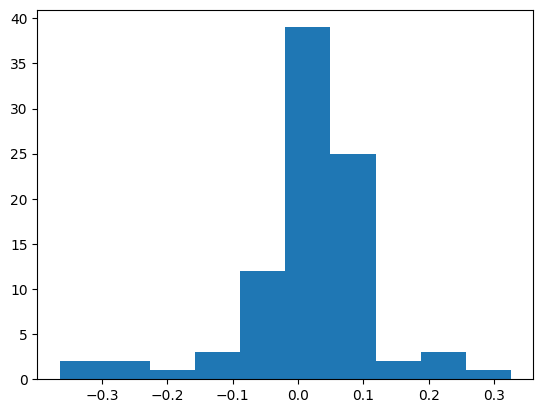

In [102]:
plt.hist(slope_predictions.slope_residual)

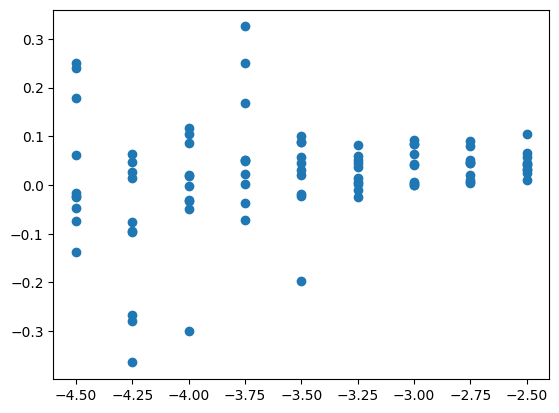

In [103]:
plt.scatter(slope_predictions.slope, slope_predictions.slope_residual)

In [104]:
plot_data = slope_predictions[
    slope_predictions.rim_erasure_exponent.isin([0.2, .9])
].copy()
# plot_data = slope_predictions

In [105]:
lower_bound = plot_data.mle_slope - 1.5 * plot_data.mle_sigma
upper_bound = plot_data.mle_slope + 1.5 * plot_data.mle_sigma
plot_data[~plot_data.implied_slope.between(lower_bound, upper_bound)].sort_values(["slope", "rim_erasure_exponent"])

simulation_id  slope  rim_erasure_exponent  nobs_max  lifespan_exponent  \
18             32  -3.75                   0.2       582           0.355351   
66             42  -3.50                   0.2       842           0.307186   
72             72  -2.75                   0.2      2533           0.162691   
61             79  -2.75                   0.9      6145           0.732111   
13             89  -2.50                   0.9      6082           0.515369   

    implied_slope  mle_slope  mle_sigma  slope_residual  
18      -3.394649    -3.7203   0.154514        0.325651  
66      -3.192814    -2.9950   0.105951       -0.197814  
72      -2.587309    -2.6681   0.053078        0.080791  
61      -2.017889    -2.0623   0.026486        0.044411  
13      -1.984631    -2.0291   0.026155        0.044469

In [106]:
plot_data[~plot_data.implied_slope.between(lower_bound, upper_bound)].shape

(5, 9)

In [107]:
plot_data.shape

(18, 9)

/tmp/ipykernel_2472055/2540231649.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(d.slope, d.implied_slope, marker="x", c=plt.cm.viridis(norm(exponent)))


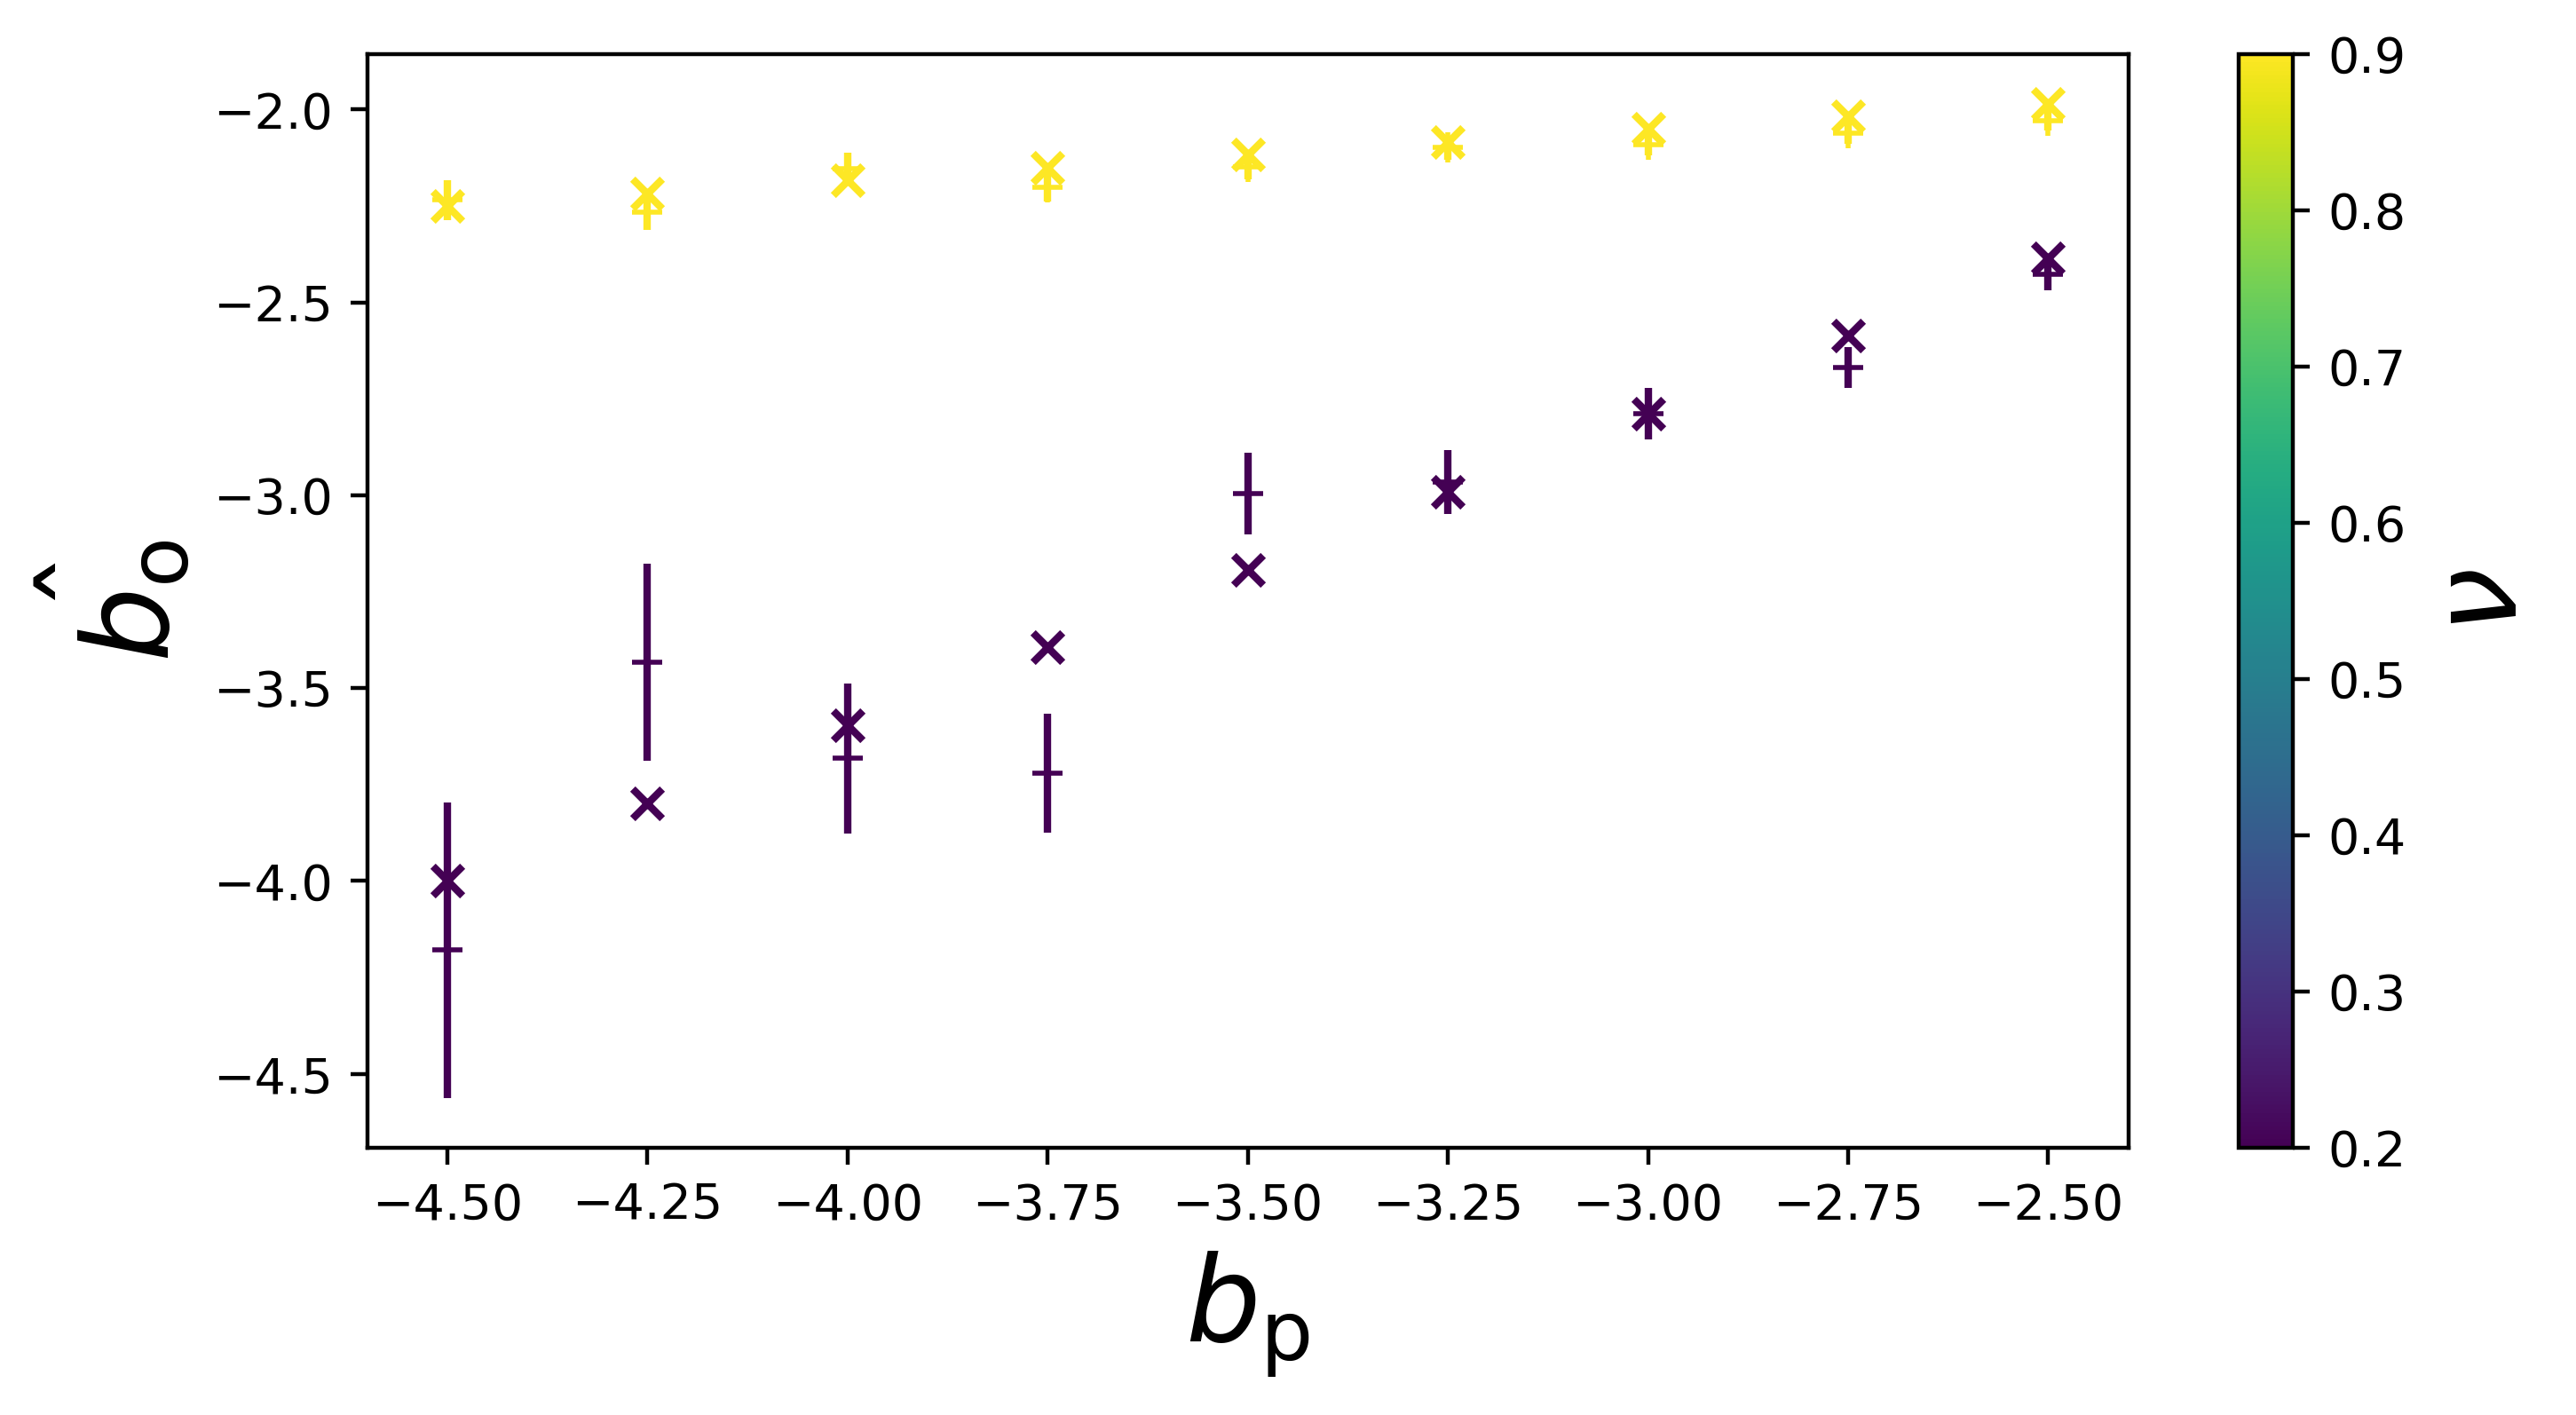

In [108]:
fig = plt.figure(figsize=(8, 4), dpi=dpi)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(plot_data["rim_erasure_exponent"].min(), plot_data["rim_erasure_exponent"].max())

for exponent in plot_data.rim_erasure_exponent.drop_duplicates().sort_values():
    d = plot_data[plot_data.rim_erasure_exponent == exponent].sort_values("slope").copy()
    ax.errorbar(
        d.slope,
        d.mle_slope,
        d.mle_sigma,
        marker="+",
        ls="",
        color=plt.cm.viridis(norm(exponent)),
        ecolor=plt.cm.viridis(norm(exponent))
    )
    ax.scatter(d.slope, d.implied_slope, marker="x", c=plt.cm.viridis(norm(exponent)))

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\nu$", fontsize=font_size)

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=font_size)
ax.set_ylabel(r"$\hat{b_{\text{o}}}$", fontsize=font_size)

plt.savefig("figures/estimated_slopes.png", bbox_inches="tight")

plt.show()

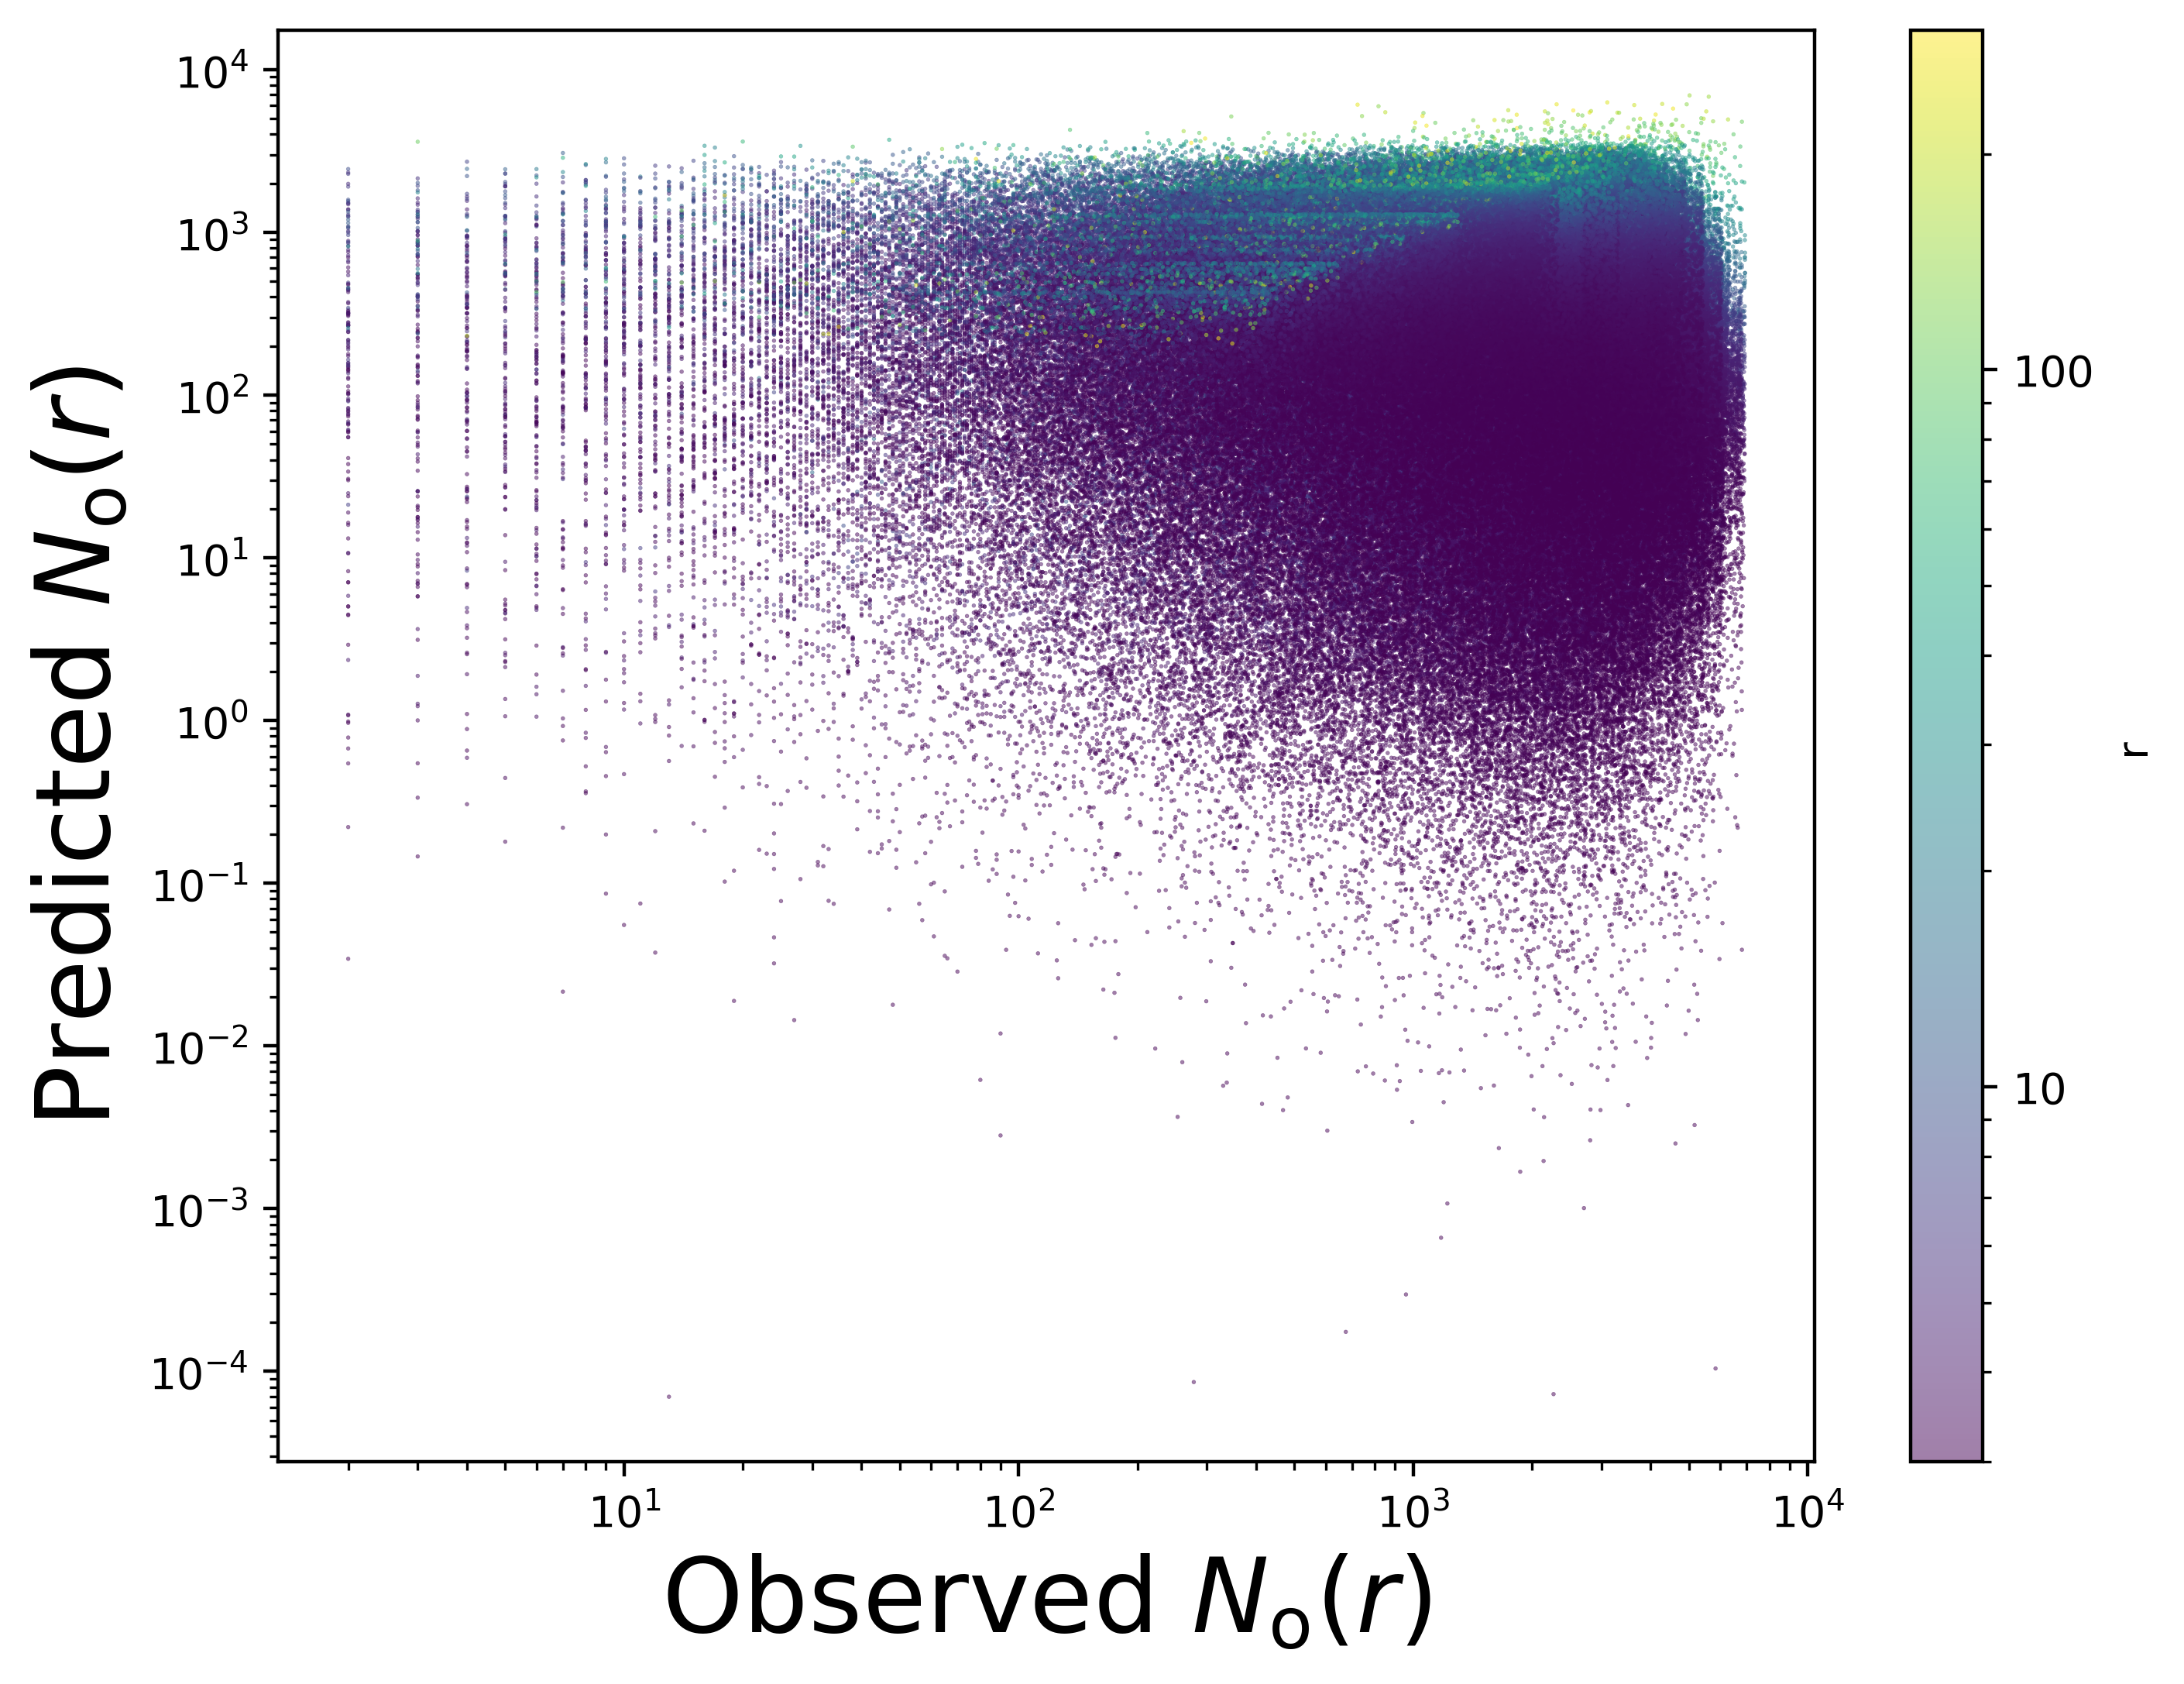

In [141]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = estimates.radius
scatter = ax.scatter(
    estimates.nobs_geq_r,
    estimates.predicted_nobs,
    c=color_var,
    s=0.75,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel(r"Observed $N_{\text{o}}(r)$", fontsize=font_size)
ax.set_ylabel(r"Predicted $N_{\text{o}}(r)$", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

AttributeError: 'DataFrame' object has no attribute 'obs_n_gte_r'

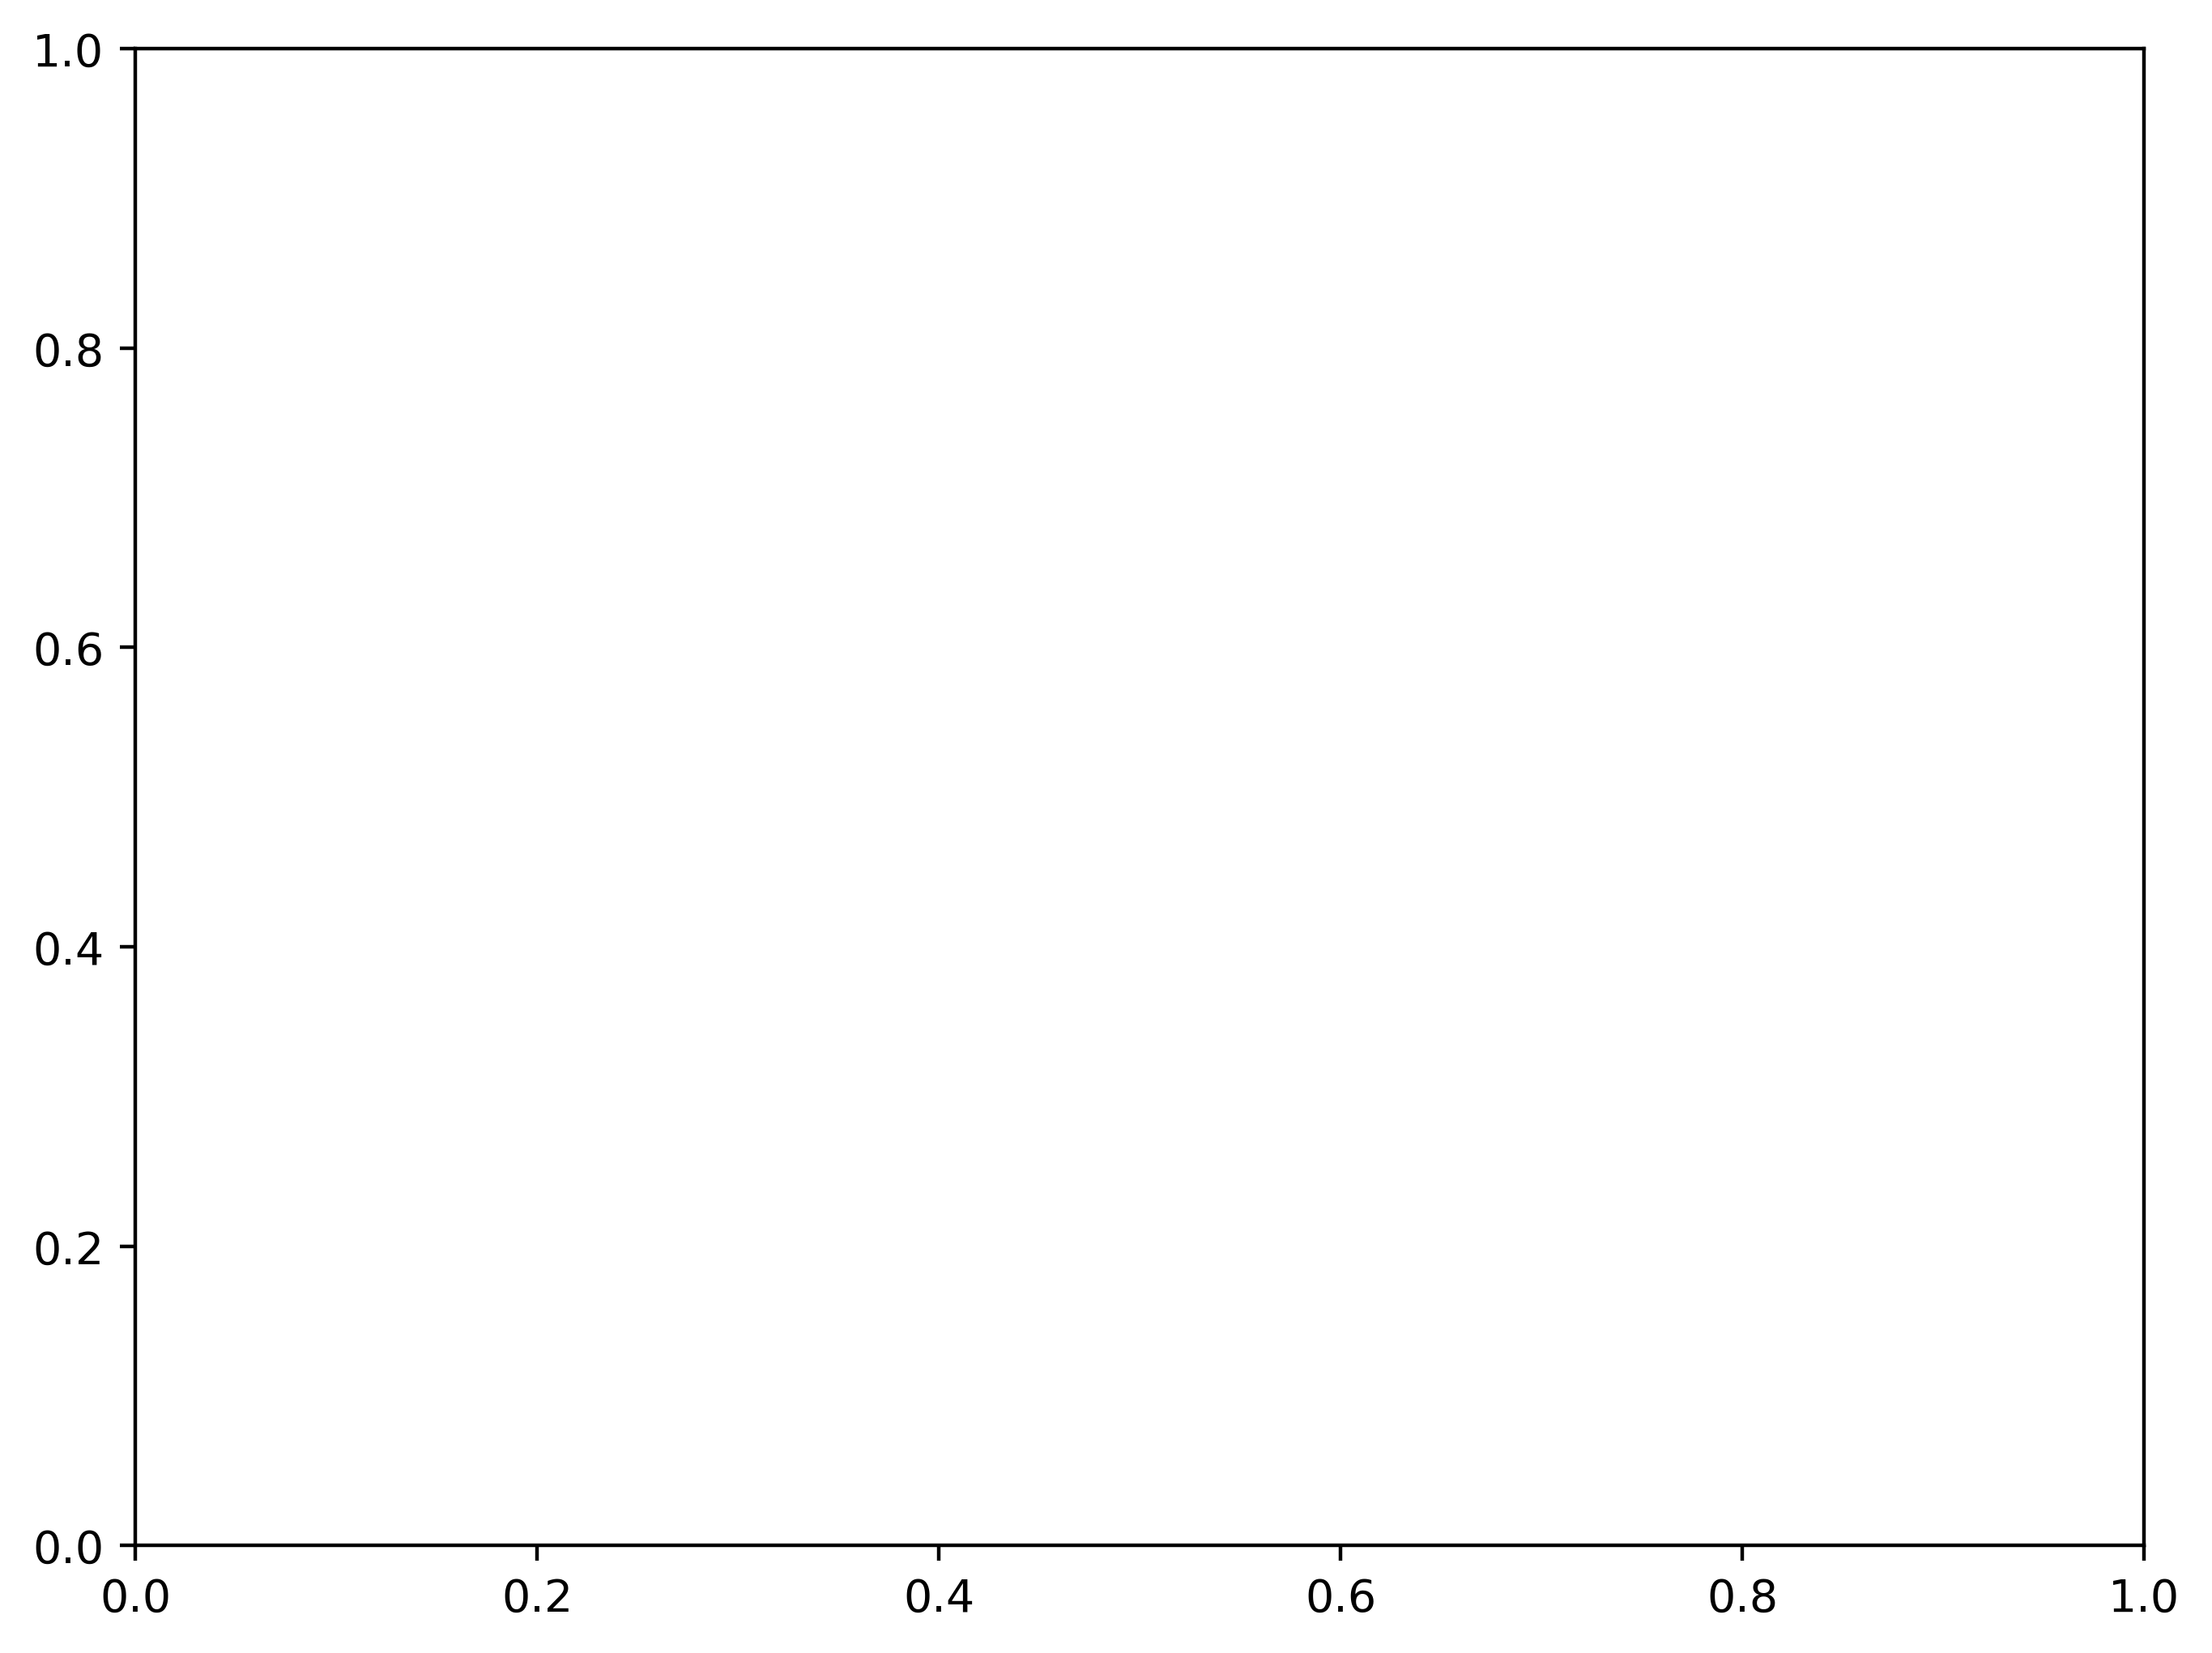

In [142]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = estimates.radius
scatter = ax.scatter(
    estimates.obs_n_gte_r,
    estimates.residual,
    c=color_var,
    s=0.75,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel(r"Observed $N_{\text{0}}(r)$", fontsize=font_size)
ax.set_ylabel("Residual", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim([1/estimates.residual.abs().max(), estimates.residual.abs().max()])

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

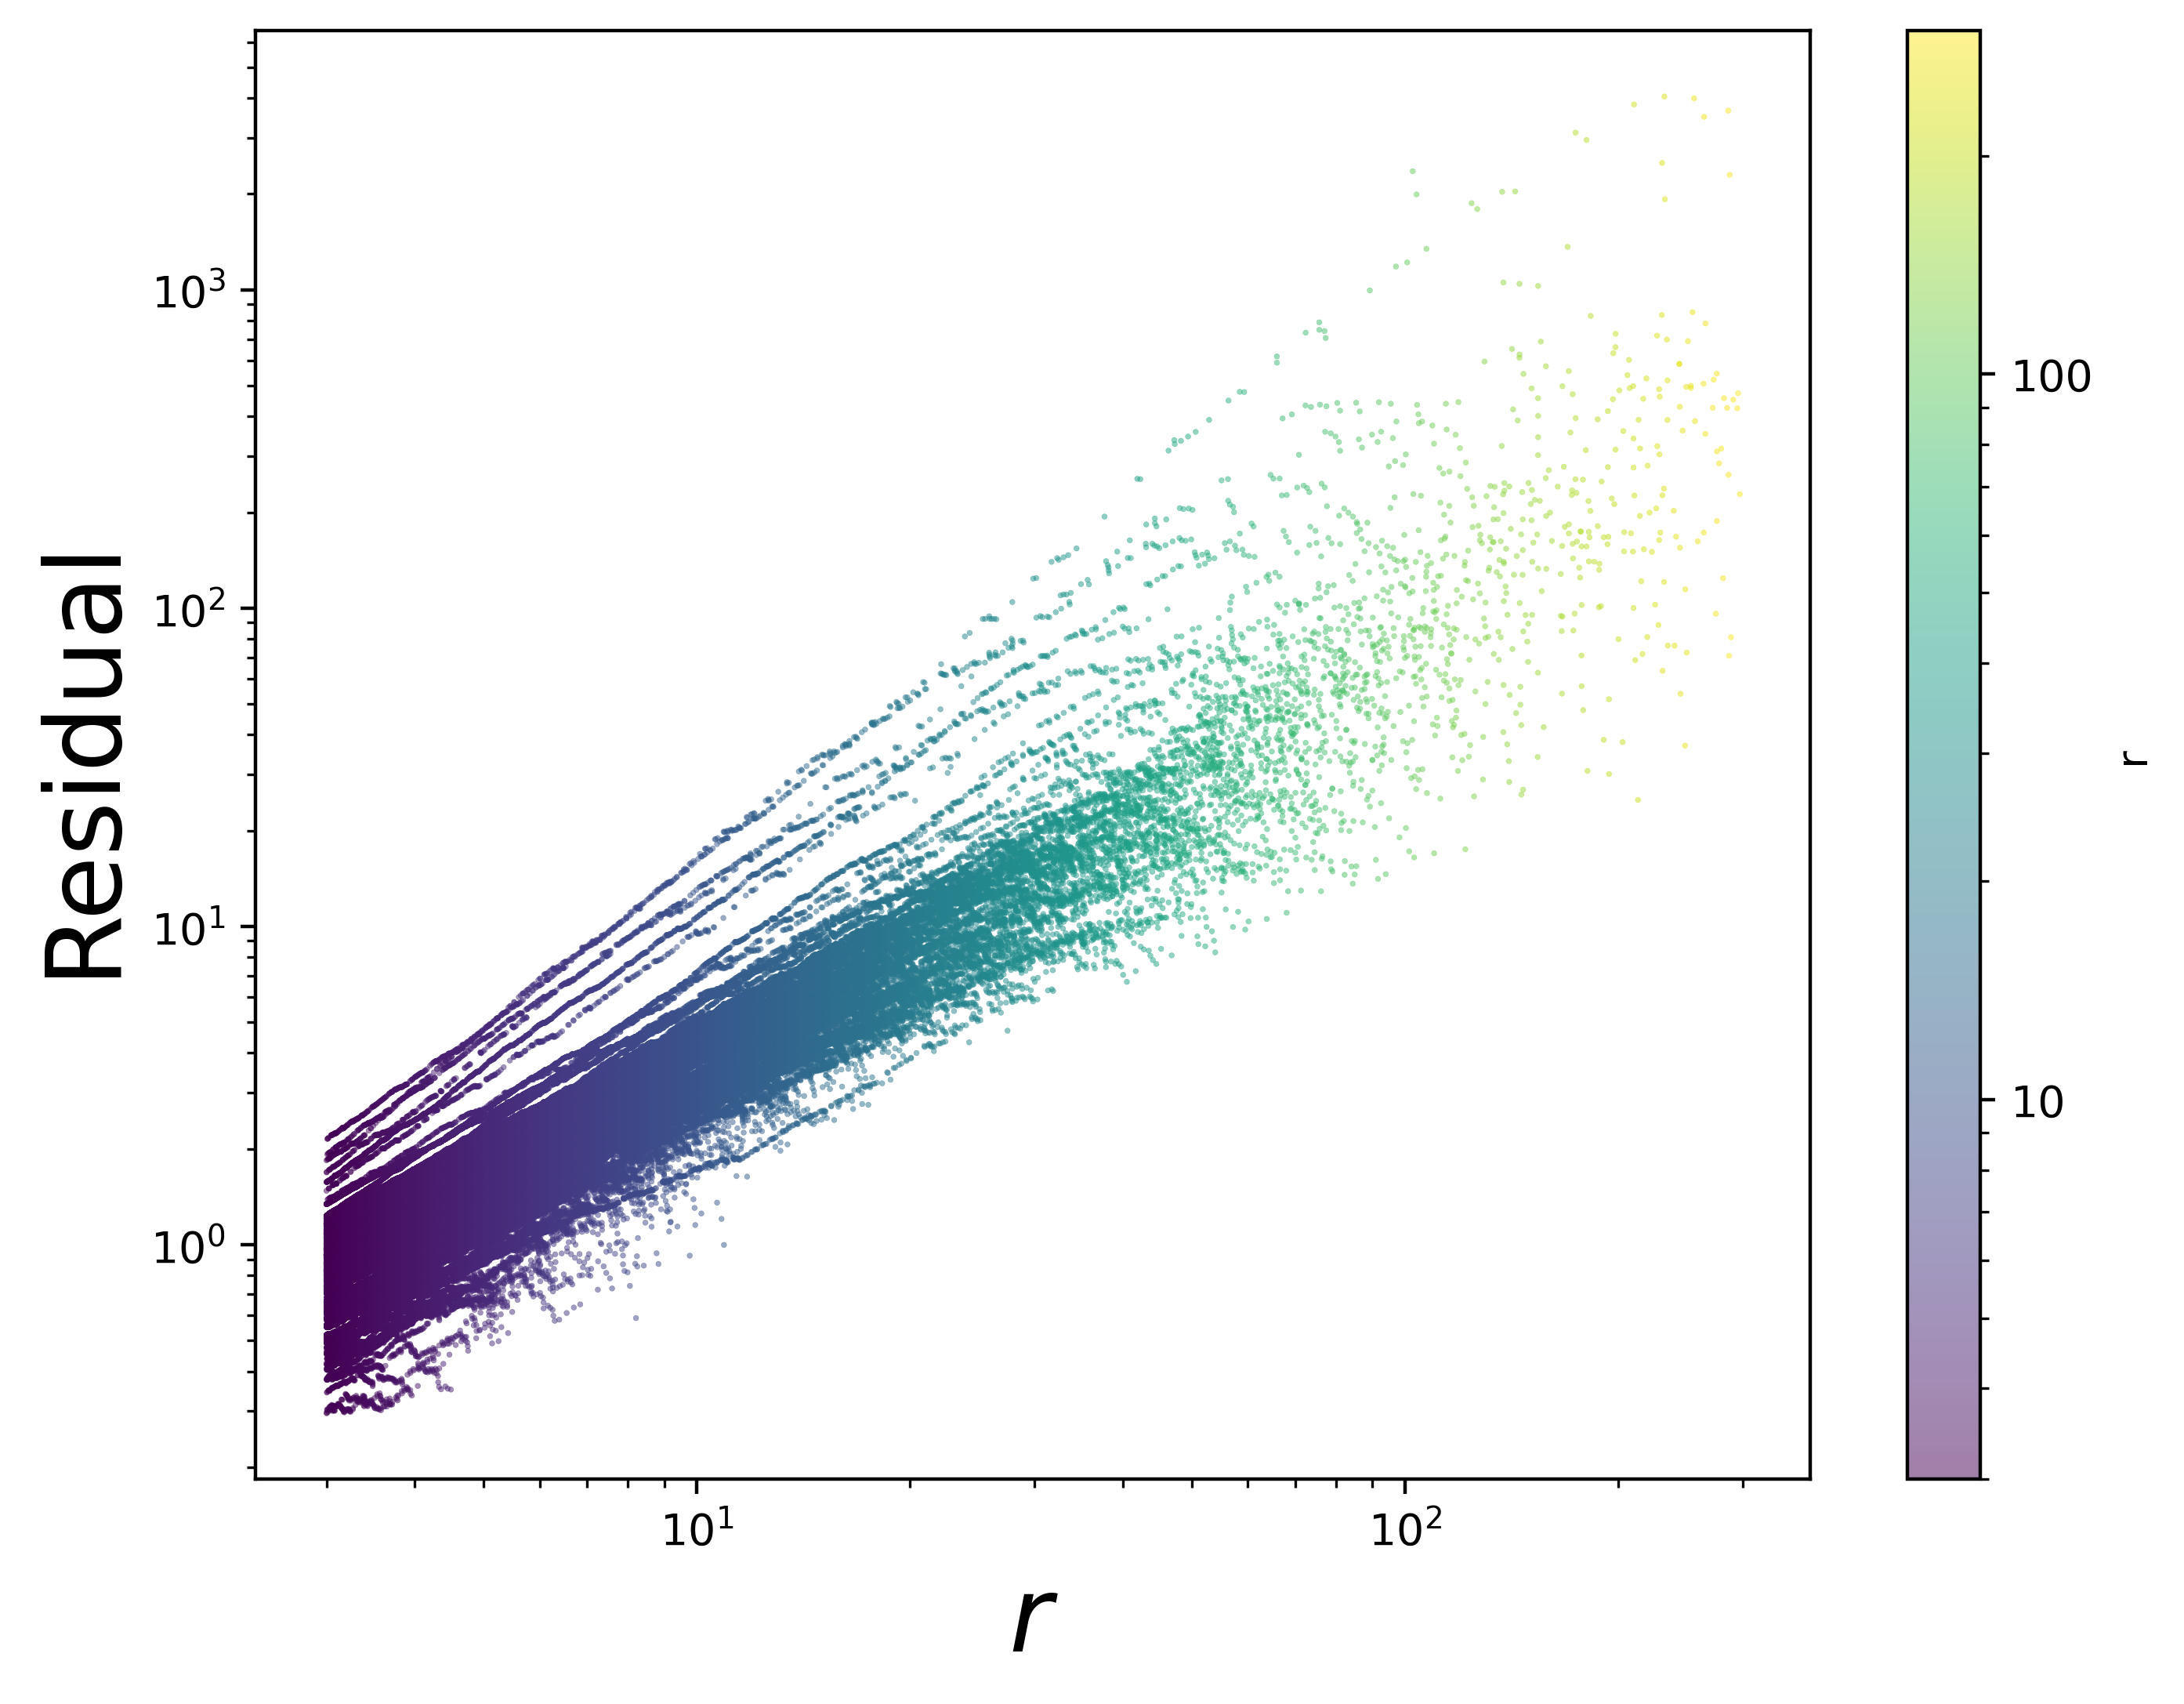

In [99]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = estimates.radius
scatter = ax.scatter(
    estimates.radius,
    estimates.residual,
    c=color_var,
    s=1.5,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("Residual", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

In [78]:
estimates["b_p"] = [configs_dict[x]["slope"] for x in estimates.simulation_id]
estimates["exponent"] = [configs_dict[x]["rim_erasure_method"]["exponent"] for x in estimates.simulation_id]

In [70]:
d = estimates[estimates.residual > estimates.residual.quantile(0.95)]
print(d.shape)

fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = d.residual
scatter = ax.scatter(
    d.radius,
    d.residual,
    c=color_var,
    s=1.5,
    norm=LogNorm(vmin=color_var.min(), vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel("$b_p$", fontsize=font_size)
ax.set_ylabel("Residual", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

(19085, 17)
